In [1]:
from tqdm import tqdm
import os
import glob
import pybedtools as pbt
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from ipyparallel import Client
from scipy.stats import binom_test
from scipy.stats import norm

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

30

### Split Remap bed file by TF and then for each TF by chromosome

In [3]:
out_handles = {}
os.system('rm -rf ../data/REMAP_TFBS/tf_wise_files')
os.system('mkdir ../data/REMAP_TFBS/tf_wise_files')

with open('../data/REMAP_TFBS/nrPeaks_all.bed') as handle:
    for line in tqdm(handle):
        cols = line.split('\t')
        tf_name = cols[3]
        if tf_name not in out_handles:
            out_name = '../data/REMAP_TFBS/tf_wise_files/' + tf_name + '.bed'
            out_handles[tf_name] = open(out_name, 'w')
        pos = int(cols[6])
        start = pos - 25
        stop = pos + 25
        out_line = "\t".join([cols[0], str(start), str(stop)])
        out_handles[tf_name].write(out_line+'\n')

for each_tf in out_handles:
    out_handles[each_tf].close()

8773705it [01:05, 134973.35it/s]


In [5]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']

for tf_name in tqdm(out_handles):
    out_dir = "../data/REMAP_TFBS/tf_wise_files/%s" % tf_name
    os.system('rm -rf %s' % out_dir)
    os.system('mkdir %s' % out_dir)
    in_file = '../data/REMAP_TFBS/tf_wise_files/' + tf_name + '.bed'
    chrom_out_handles = {x: open("%s/%s.bed" % (out_dir, x), 'w') for x in chroms}
    with open(in_file) as handle:
        for line in handle:
            chrom = line.split('\t')[0]
            if chrom == 'chrM':
                continue
            chrom_out_handles[chrom].write(line)
    for chrom in chrom_out_handles:
        chrom_out_handles[chrom].close()
        
for tf_name in tqdm(out_handles):
    in_file = '../data/REMAP_TFBS/tf_wise_files/' + tf_name + '.bed'
    os.system("rm %s" % in_file)

100%|██████████| 237/237 [00:04<00:00, 56.94it/s]


### Calculate Expectation score within each peak for each TF

180 240
120 180
60 120
0 60


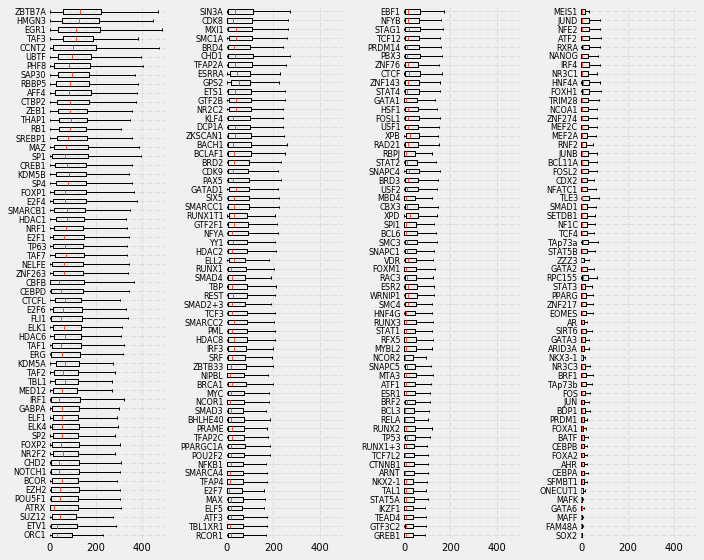

In [52]:
def get_scores_in_peaks(chrom):
    
    import numpy as np
    import glob

    def bed_to_intervals(fn):
        intervals = []
        with open(fn) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                intervals.append((int(c[1]), int(c[2])))
        return intervals

    in_dir = '/home/parashar/scratch/quadcomb/data/snipr'
    pos = np.load('%s/%s_positive_scores.npy' % (in_dir, chrom))
    neg = np.load('%s/%s_negative_scores.npy' % (in_dir, chrom))
    
    base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
    tfs = [x.split('/')[-1] for x in sorted(glob.glob("%s/*" % base_dir))]
    res = []
    for tf in tfs:
        intervals = bed_to_intervals("%s/%s/%s.bed" % (base_dir, tf, chrom))
        if len(intervals) > 0:
            s_p = [np.mean(pos[i[0]:i[1]]) for i in intervals]
            s_n = [np.mean(neg[i[0]:i[1]]) for i in intervals]
            score = np.array(s_p) + np.array(s_n)            
            res.append(list(score))
        else:
            res.append([])
    return res

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
tfs = np.array([x.split('/')[-1] for x in sorted(glob.glob("%s/*" % base_dir))])
rep_res = DVIEW.map_sync(get_scores_in_peaks, chroms)
chrom_aggregated = [[] for x in range(len(tfs))]
for i in rep_res:
    for j in range(len(tfs)):
        chrom_aggregated[j].extend(i[j])

agg_means = np.array([np.mean(chrom_aggregated[x]) for x in range(len(tfs))])
idx = np.argsort(agg_means)

fig, axis = plt.subplots(1, 4, figsize=(10, 8))

start, end = (180, len(idx)+1)
for ax in axis:
    print (start, end)
    ax.boxplot([chrom_aggregated[x] for x in idx[start:end]], sym='', vert=False)
    ax.set_yticklabels(tfs[idx[start:end]], fontsize=8)
    start -= 60
    end -= 60
    ax.set_xlim((0, 500))
    ax.xaxis.set_tick_params(labelsize=10)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
        ax.grid(which='major', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../images/tfbs_mean_scores_dist.svg', transparent=True, edgecolor='none')
plt.show()

180 240
120 180
60 120
0 60


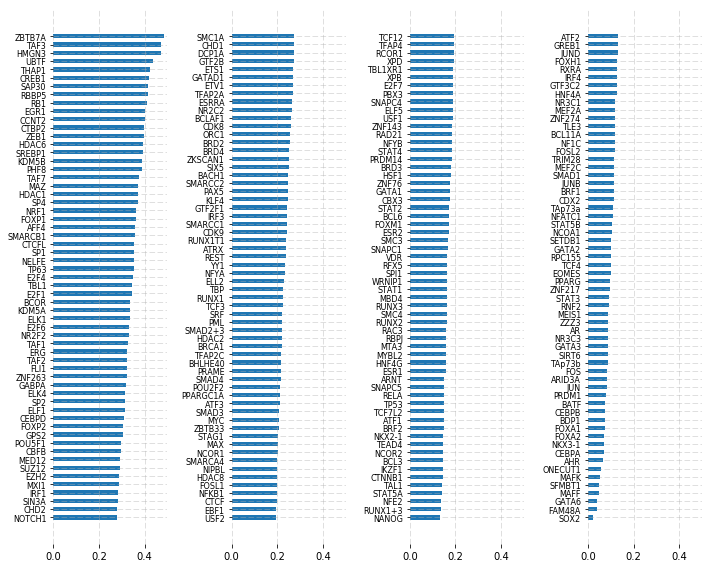

In [2]:
def get_scores_in_peaks(chrom):
    
    import numpy as np
    import glob

    def bed_to_intervals(fn):
        intervals = []
        with open(fn) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                intervals.append((int(c[1]), int(c[2])))
        return intervals

    in_dir = '/home/parashar/scratch/quadcomb/data/snipr'
    pos = np.load('%s/%s_positive_scores.npy' % (in_dir, chrom))
    neg = np.load('%s/%s_negative_scores.npy' % (in_dir, chrom))
    
    base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
    tfs = [x.split('/')[-1] for x in sorted(glob.glob("%s/*" % base_dir))]
    res = []
    for tf in tfs:
        intervals = bed_to_intervals("%s/%s/%s.bed" % (base_dir, tf, chrom))
        if len(intervals) > 0:
            sp = [1 if len(np.where(pos[i[0]:i[1]] >= 185)[0]) > 0 else 0 for i in intervals]
            sn = [1 if len(np.where(neg[i[0]:i[1]] >= 185)[0]) > 0 else 0 for i in intervals]
            res.append((sum(sp) + sum(sn))/(2*len(intervals)))
        else:
            res.append(0)
    return res

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
tfs = np.array([x.split('/')[-1] for x in sorted(glob.glob("%s/*" % base_dir))])
rep_res = DVIEW.map_sync(get_scores_in_peaks, chroms)
chrom_aggregated_count = [0 for x in range(len(tfs))]
for i in rep_res:
    for j in range(len(tfs)):
        chrom_aggregated_count[j]+=i[j]
chrom_aggregated_count = np.array(chrom_aggregated_count)/24

idx = np.argsort(chrom_aggregated_count)
fig, axis = plt.subplots(1, 4, figsize=(10, 8))
start, end = (180, len(idx)+1)
for ax in axis:
    print (start, end)
    ax.barh(range(len(idx[start:end])), chrom_aggregated_count[idx[start:end]], height=0.5)
    ax.set_yticks(range(len(idx[start:end])))
    ax.set_yticklabels(tfs[idx[start:end]], fontsize=8)
    start -= 60
    end -= 60
    ax.set_xlim((0, 0.5))
    ax.xaxis.set_tick_params(labelsize=10)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
        ax.grid(which='major', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../images/tfbs_coverage_above25.svg', transparent=True, edgecolor='none')
plt.show()

In [9]:
all_pvals = []
for tf in tfs:
    pvals = np.load('../data/REMAP_TFBS/pvals/%s.npy' % tf)
    all_pvals.append(np.mean(pvals[0]))
all_pvals = np.array(all_pvals)

In [31]:
enrichment = []
for tf in tqdm(tfs):
    scores = []
    rand_scores = []
    for chrom in chroms:
        a = np.load('../data/REMAP_TFBS/snipr_tf/%s_%s_scores.npy' % (chrom, tf),
                    mmap_mode='r')
        b = np.load('../data/REMAP_TFBS/snipr_tf/%s_%s_random_scores.npy' % (chrom, tf),
                   mmap_mode='r')
        scores.extend(a)
        rand_scores.extend(b)
    scores = np.array(scores)
    rand_scores = np.array(rand_scores).flatten()
    enrichment.append(scores.mean()/rand_scores.mean())
enrichment = np.array(enrichment)

100%|██████████| 239/239 [11:09<00:00,  2.92s/it]


CCNT2 2.24816143285 4.08850150517 0.401141293613
CTBP2 2.01728877377 4.39352206025 0.397776308673
EGR1 2.5427932615 4.37048376392 0.403784231723
HMGN3 2.29958741118 8.44316496333 0.470166952432
KDM5B 1.89428304252 4.21727708987 0.389872675768
RBBP5 2.04143476257 4.29766887095 0.416105194308
SAP30 1.95922975465 5.04003185166 0.416109816509
TAF3 2.09752839602 8.09657202898 0.473053520909
THAP1 1.85900975001 5.08751456649 0.425743544155
UBTF 2.05420885978 6.3248294402 0.435792921121
ZBTB7A 2.35030533054 8.74789659458 0.485457679033
ZEB1 1.86769803003 4.44321941453 0.396904529471


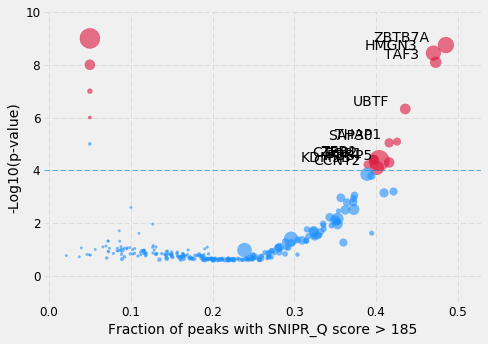

In [92]:
plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
p_cutoff = 0.01 * 1e-2

colors = np.array(['crimson' if x < p_cutoff else 'dodgerblue' for x in all_pvals])
ax.axhline(-1*np.log10(p_cutoff), lw=1, ls='--', alpha=0.6)
log_pvals = -1*np.log10(all_pvals)
ax.scatter(chrom_aggregated_count, log_pvals, alpha=0.6, lw=0,
            s=8+enrichment**6.5, c=colors)

draw_circ = [8+(x**6.5) for x in [0.5, 1, 1.5, 2, 2.5]]
ax.scatter([0.05 for x in range(len(draw_circ))], [5+x for x in range(len(draw_circ))],
            s=draw_circ, alpha=0.6, c=['dodgerblue', 'crimson', 'crimson', 'crimson', 'crimson'])

for i in range(len(tfs)):
    if all_pvals[i] < p_cutoff:
        ax.text(chrom_aggregated_count[i]-0.02, log_pvals[i],
                tfs[i], ha='right', va='bottom') 
        print (tfs[i], enrichment[i], log_pvals[i], chrom_aggregated_count[i])

ax.set_xlabel('Fraction of peaks with SNIPR_Q score > 185', fontsize=14)
ax.set_ylabel('-Log10(p-value)', fontsize=14)
ax.set_ylim((-1, 10))

clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/tfbs_exp.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/tfbs_exp.svg', transparent=True, edgecolor='none')
plt.show()

In [113]:
mean_scores = []
mean_scores_vicinity = []
sig_tfs = []
for i in range(len(tfs)):
    tf = tfs[i]
    scores = []
    scores_vicinity = []
    base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
    snipr_dir = '/home/parashar/scratch/quadcomb/data/snipr'
    for chrom in tqdm(chroms, desc=tf):
        intervals = []
        with open("%s/%s/%s.bed" % (base_dir, tf, chrom)) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                intervals.append((int(c[1]), int(c[2])))
        if len(intervals) > 0:
            pos_exp = np.load('%s/%s_positive_scores.npy' % (snipr_dir, chrom),
                              mmap_mode='r')
            for i in intervals:
                scores.append(pos_exp[i[0]:i[1]])
                scores_vicinity.append(list(pos_exp[i[0]-50:i[0]]) + \
                                       list(pos_exp[i[1]:i[1]+50]))
    mean_scores.append(np.array(scores).mean(axis=0))
    mean_scores_vicinity.append(np.array(scores_vicinity).mean(axis=0))
    clear_output()

In [115]:
mean_scores = np.array(mean_scores)

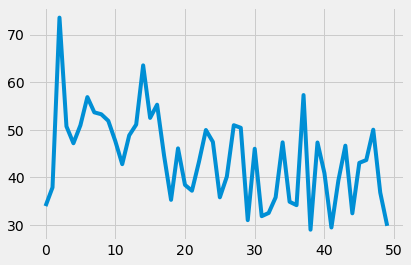

AFF4


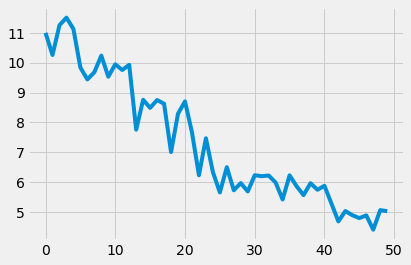

AHR


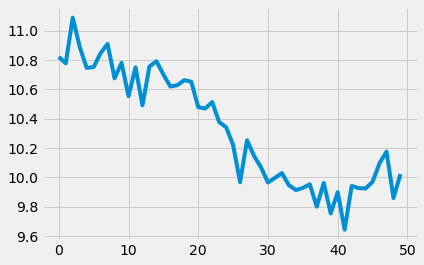

AR


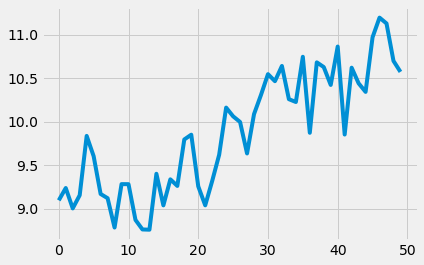

ARID3A


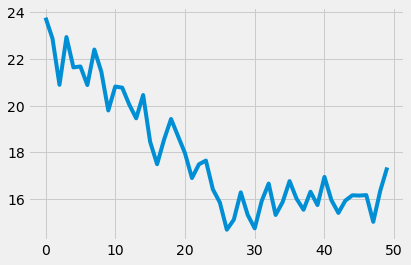

ARNT


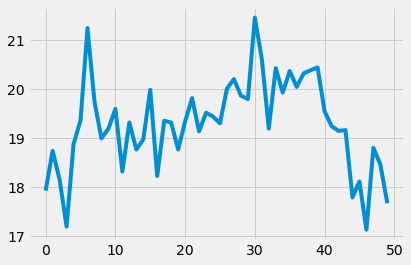

ATF1


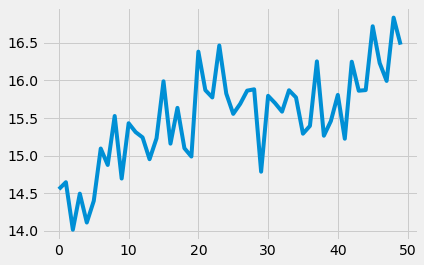

ATF2


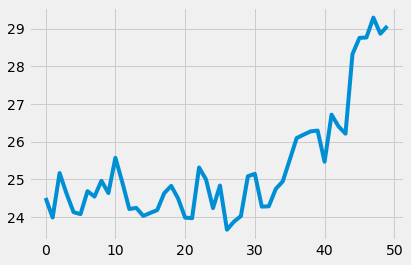

ATF3


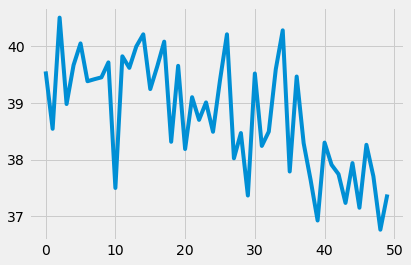

ATRX


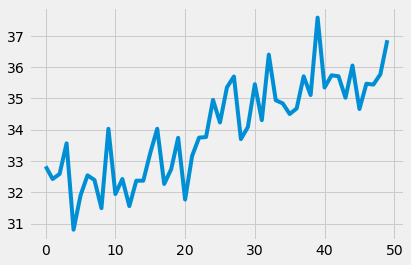

BACH1


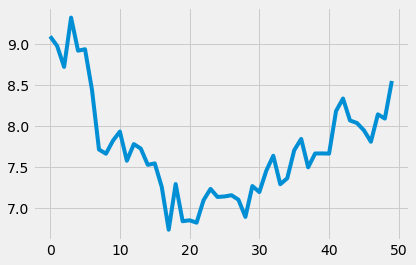

BATF


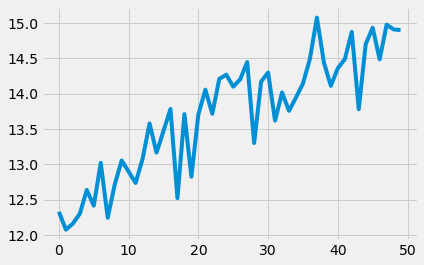

BCL11A


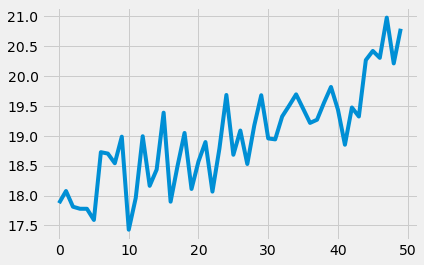

BCL3


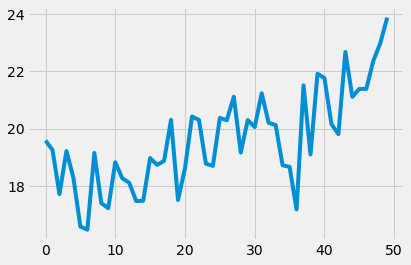

BCL6


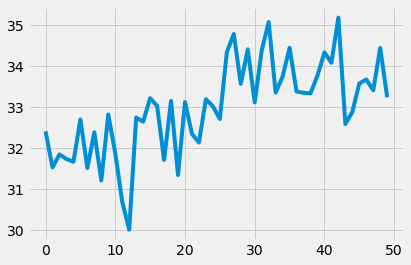

BCLAF1


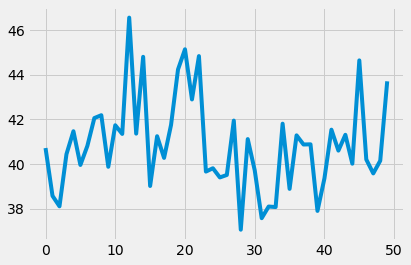

BCOR


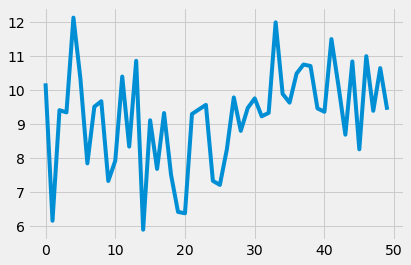

BDP1


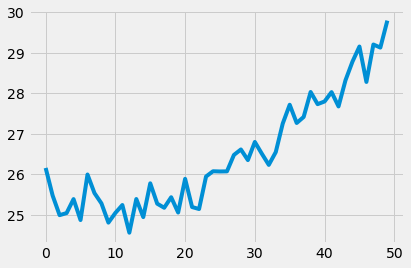

BHLHE40


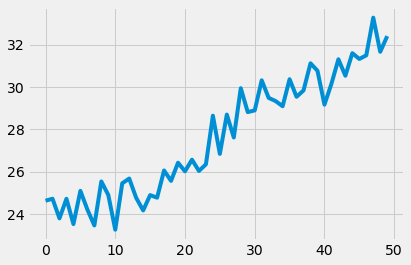

BRCA1


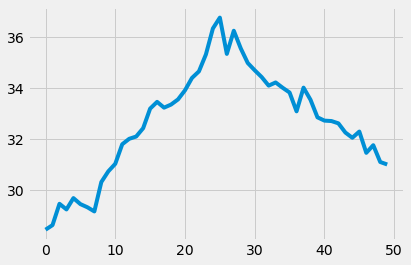

BRD2


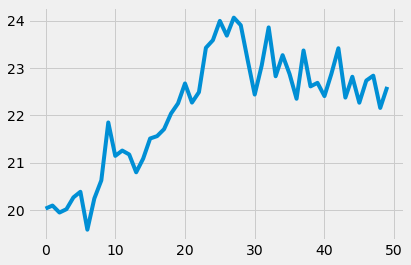

BRD3


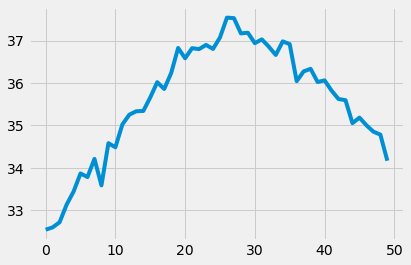

BRD4


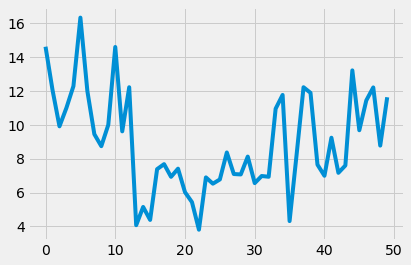

BRF1


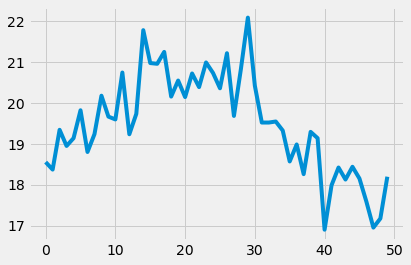

BRF2


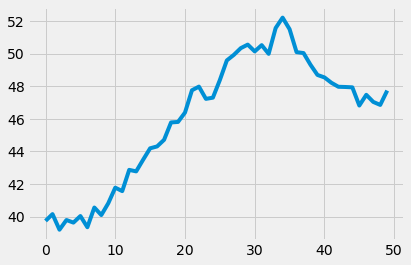

CBFB


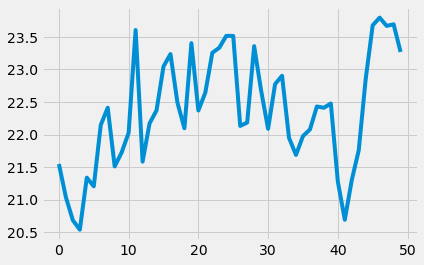

CBX3


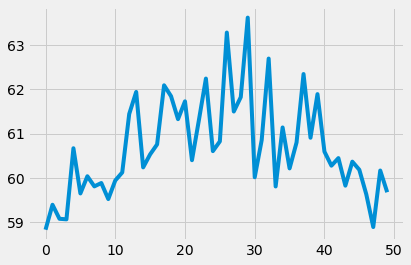

CCNT2


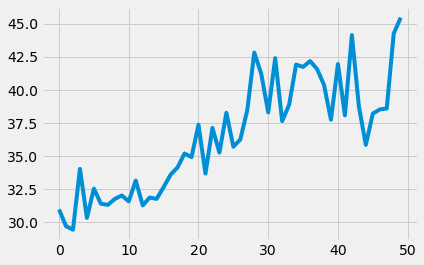

CDK8


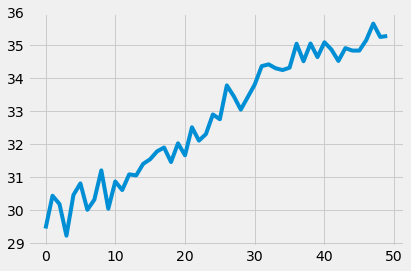

CDK9


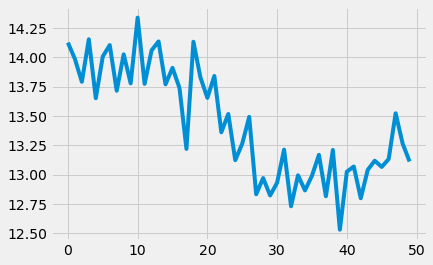

CDX2


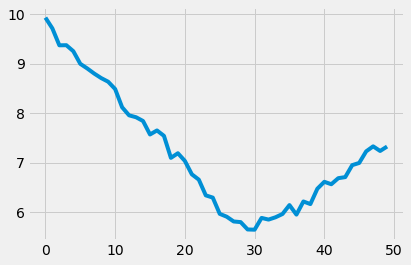

CEBPA


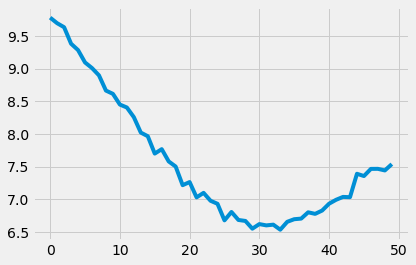

CEBPB


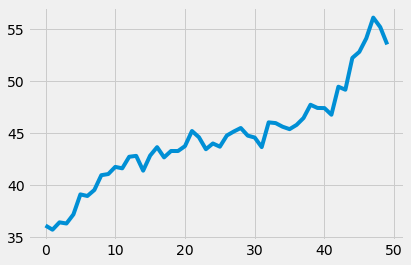

CEBPD


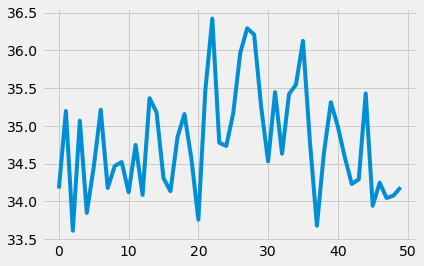

CHD1


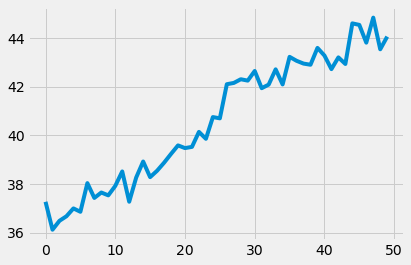

CHD2


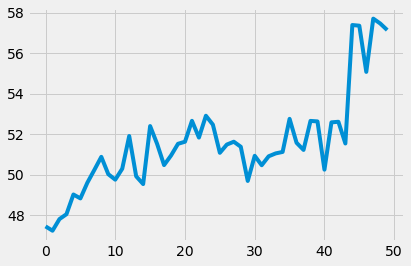

CREB1


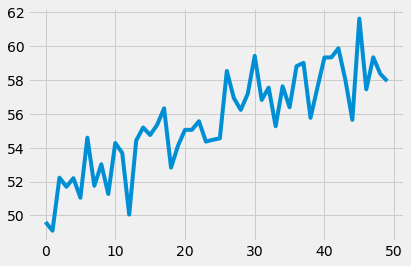

CTBP2


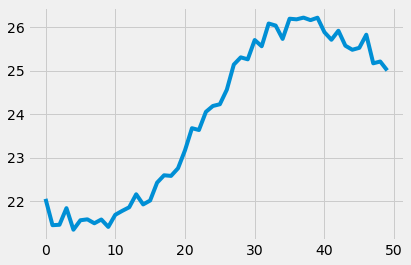

CTCF


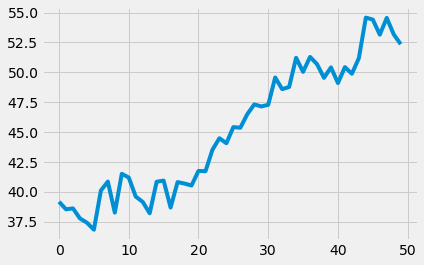

CTCFL


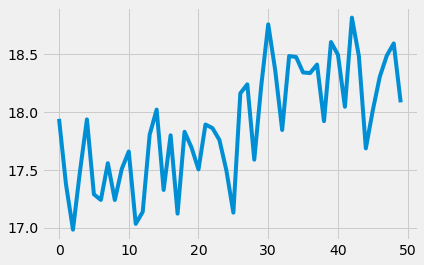

CTNNB1


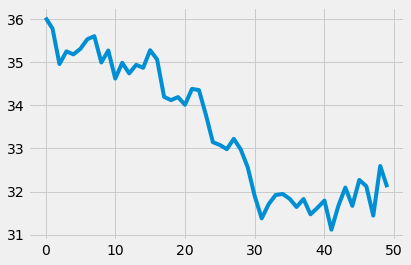

DCP1A


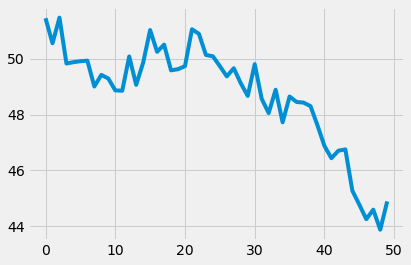

E2F1


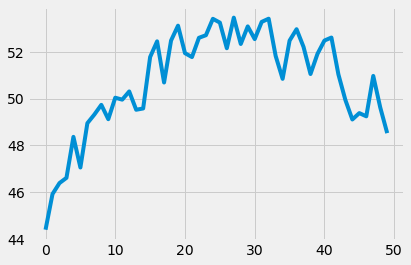

E2F4


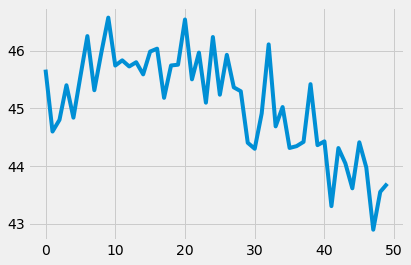

E2F6


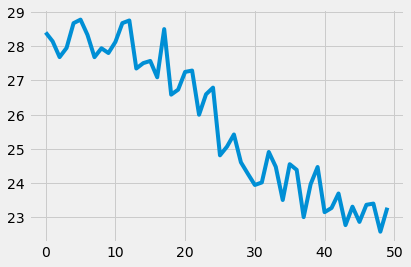

E2F7


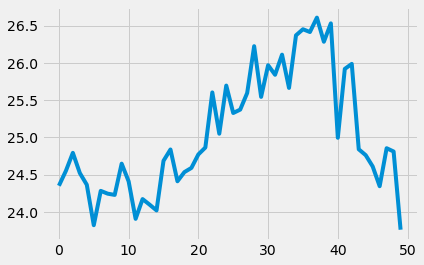

EBF1


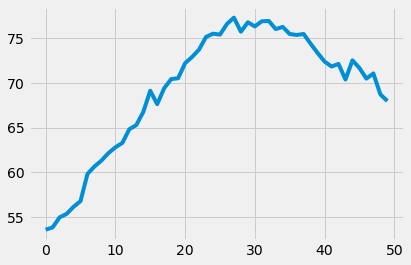

EGR1


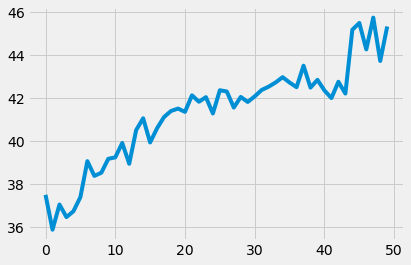

ELF1


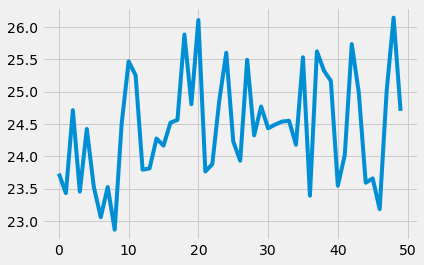

ELF5


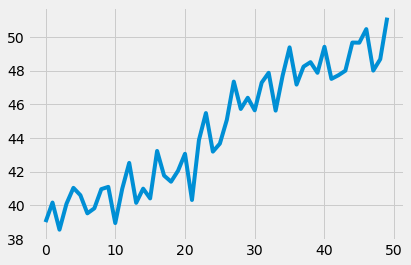

ELK1


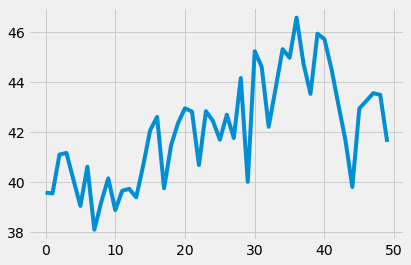

ELK4


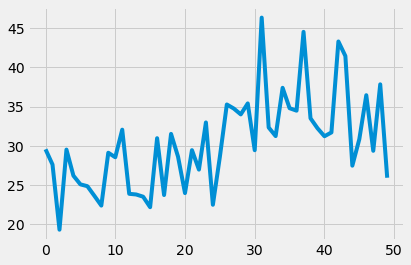

ELL2


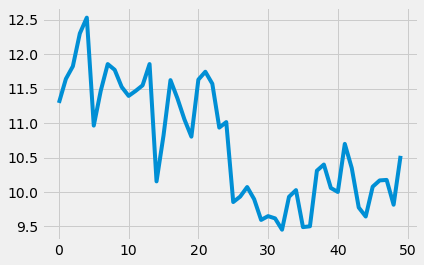

EOMES


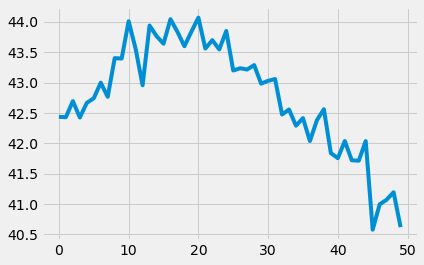

ERG


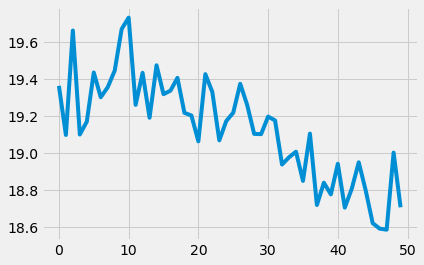

ESR1


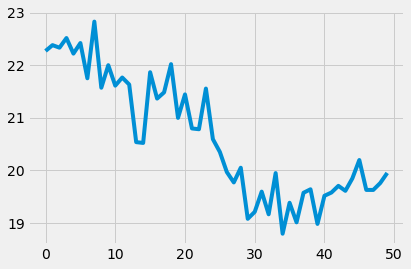

ESR2


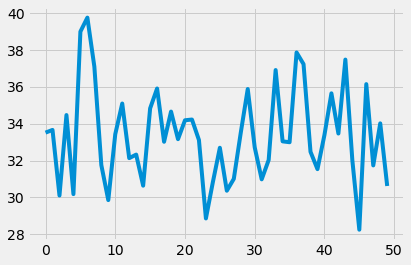

ESRRA


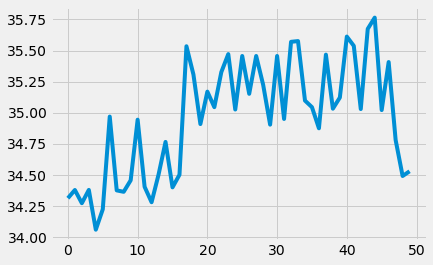

ETS1


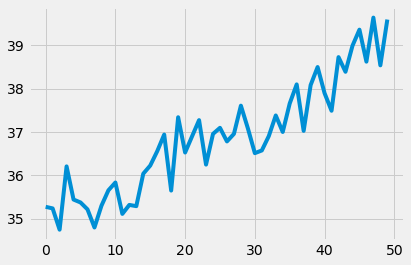

ETV1


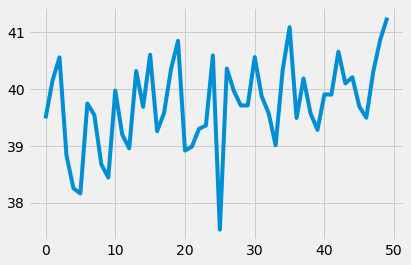

EZH2


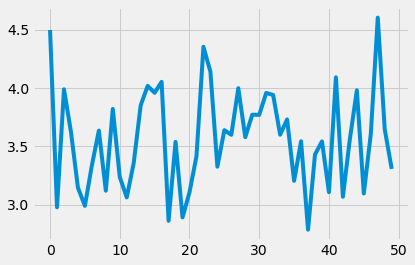

FAM48A


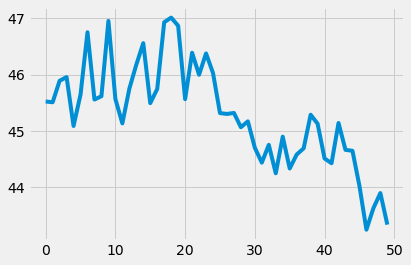

FLI1


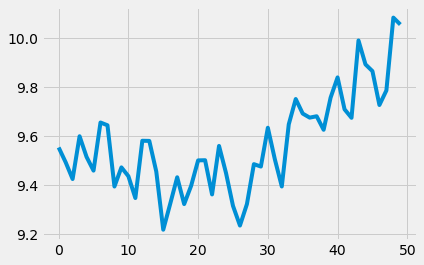

FOS


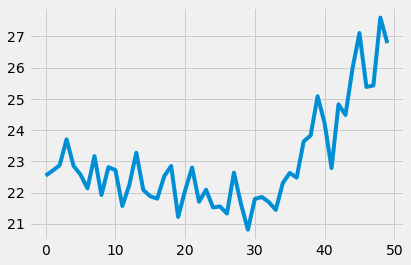

FOSL1


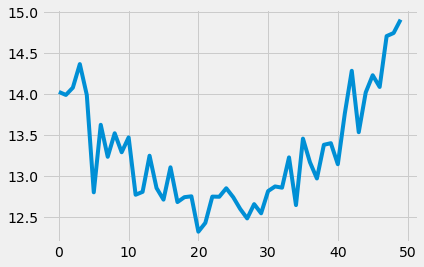

FOSL2


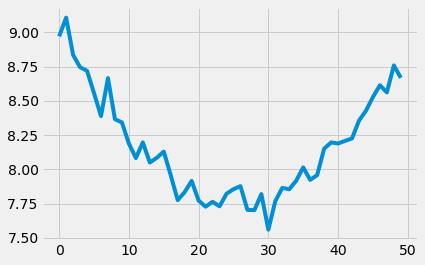

FOXA1


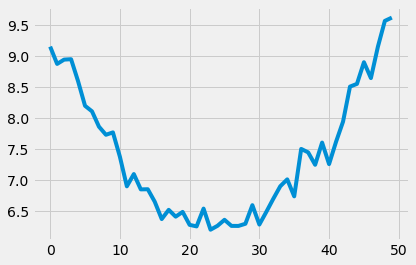

FOXA2


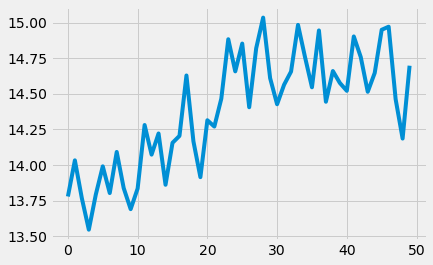

FOXH1


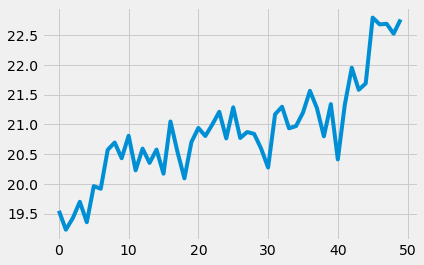

FOXM1


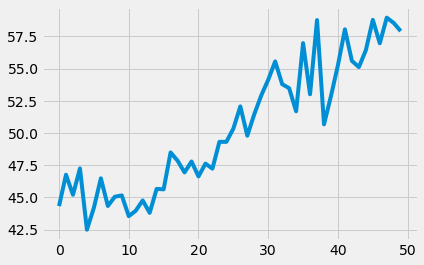

FOXP1


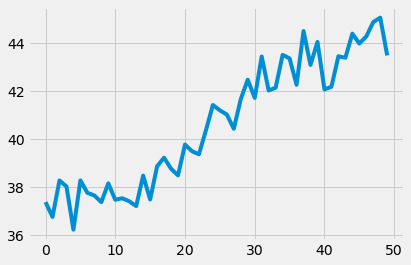

FOXP2


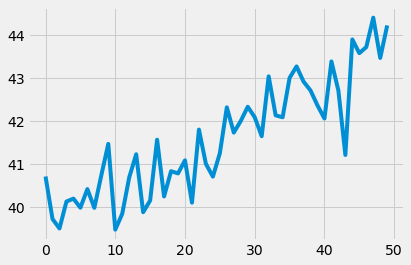

GABPA


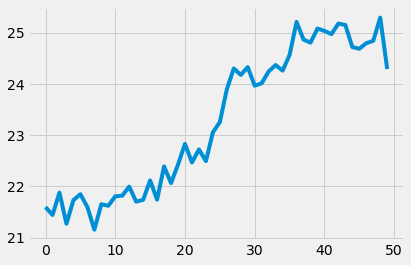

GATA1


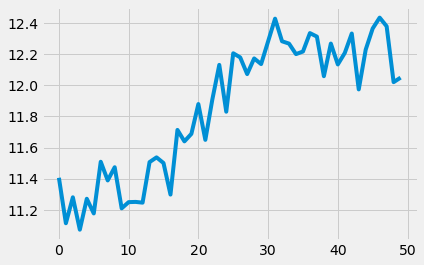

GATA2


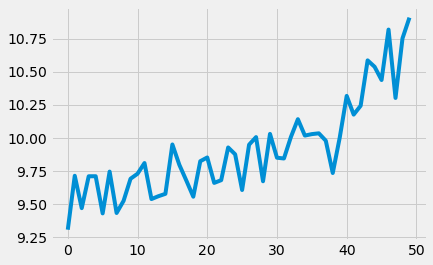

GATA3


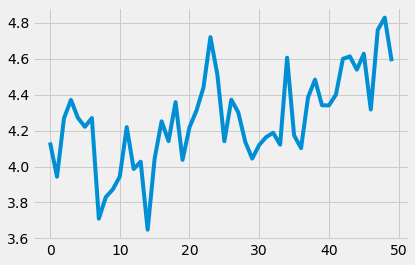

GATA6


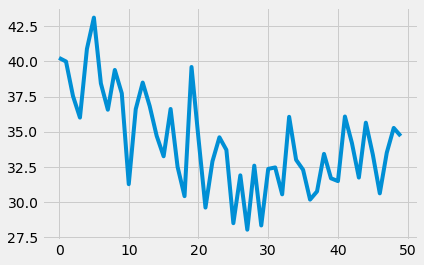

GATAD1


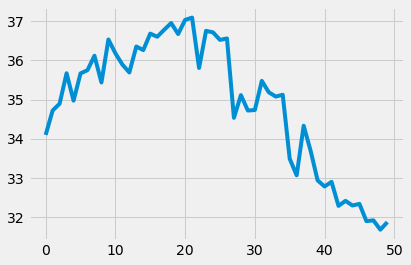

GPS2


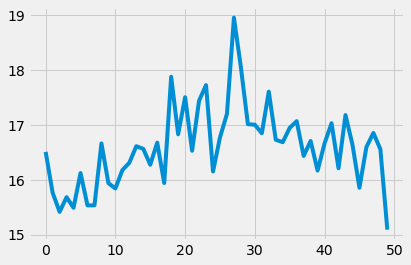

GREB1


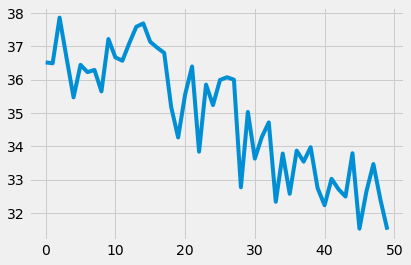

GTF2B


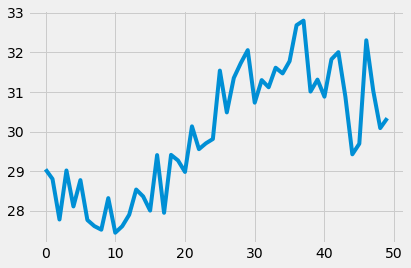

GTF2F1


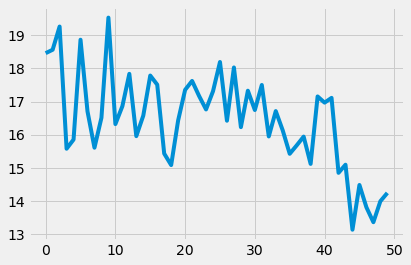

GTF3C2


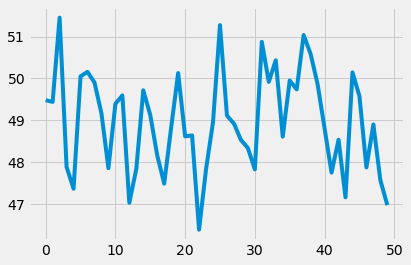

HDAC1


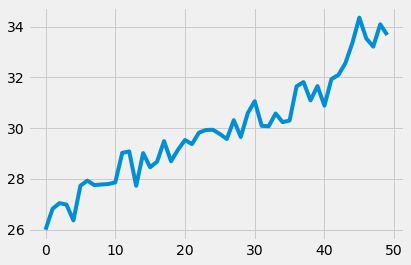

HDAC2


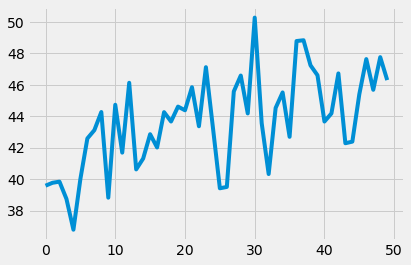

HDAC6


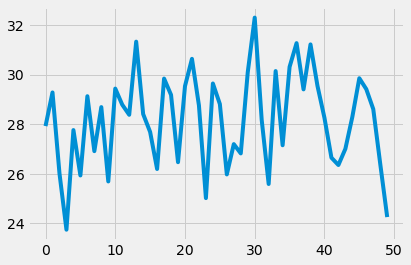

HDAC8


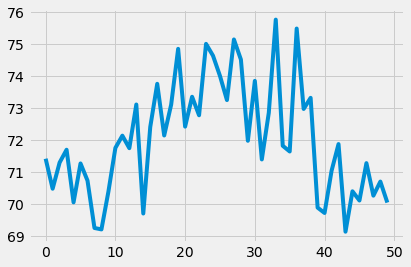

HMGN3


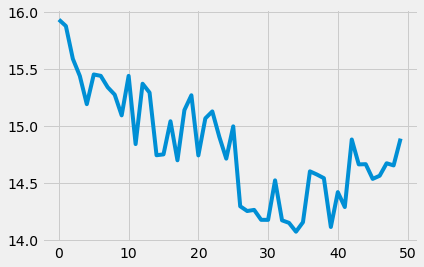

HNF4A


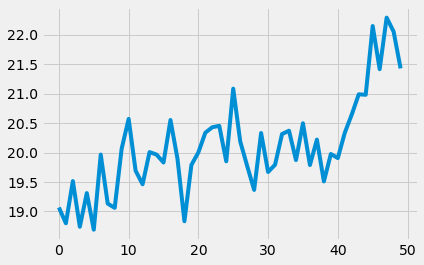

HNF4G


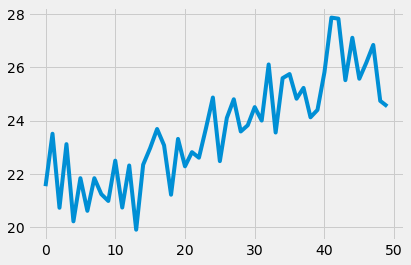

HSF1


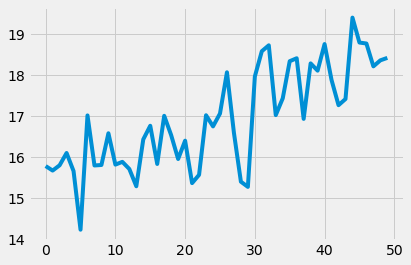

IKZF1


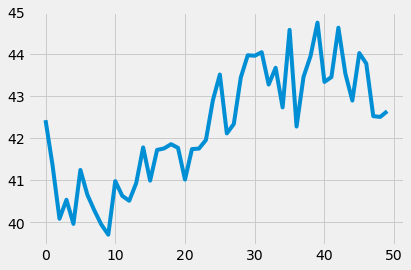

IRF1


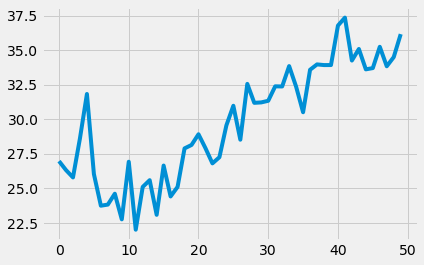

IRF3


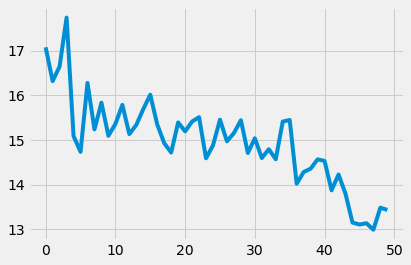

IRF4


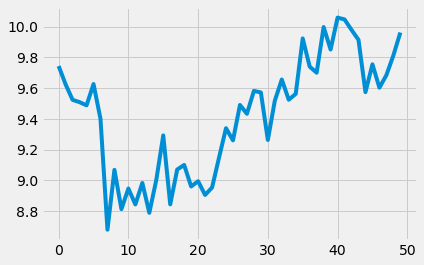

JUN


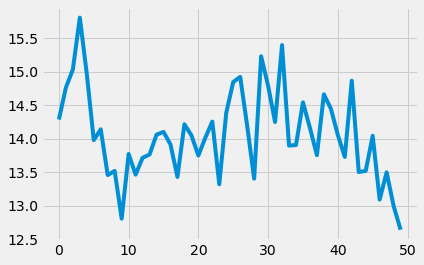

JUNB


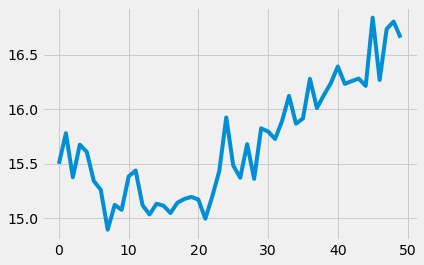

JUND


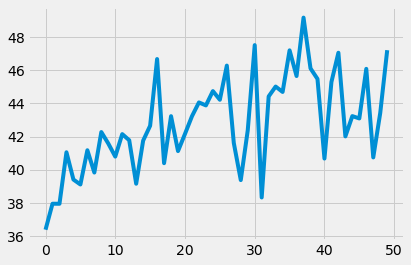

KDM5A


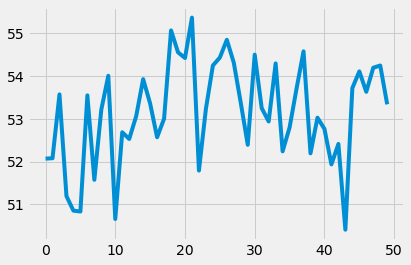

KDM5B


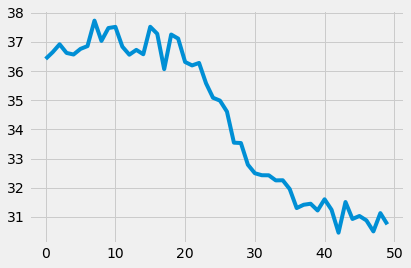

KLF4


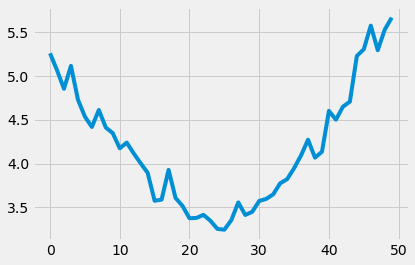

MAFF


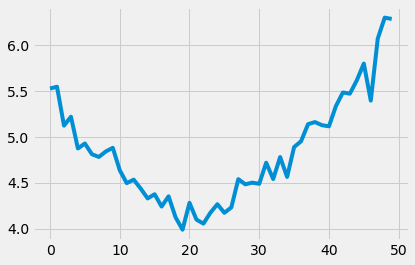

MAFK


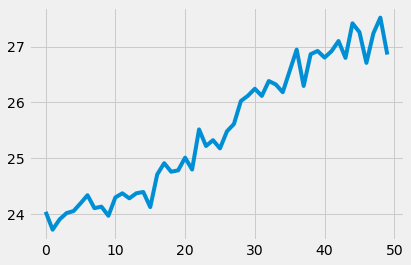

MAX


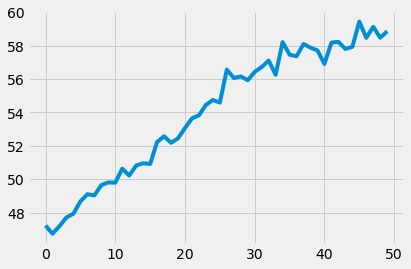

MAZ


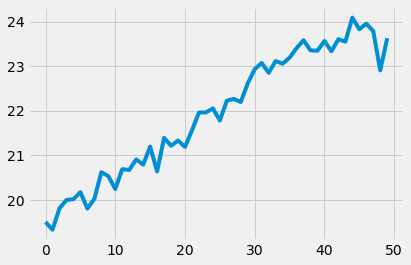

MBD4


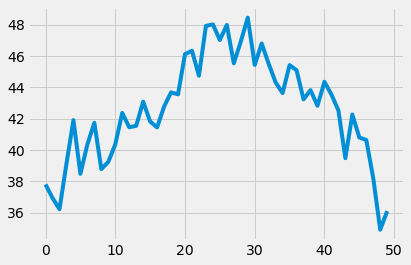

MED12


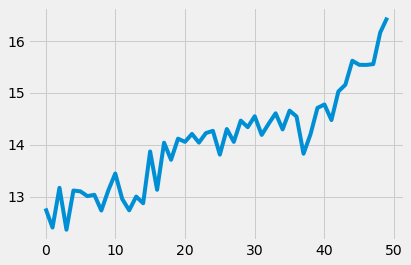

MEF2A


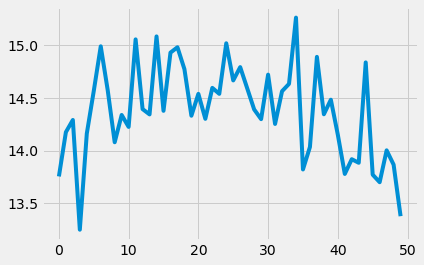

MEF2C


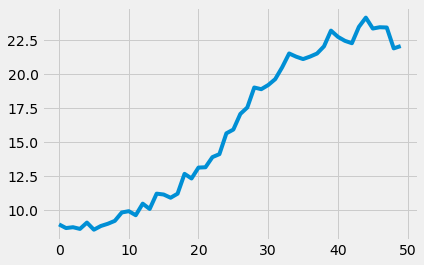

MEIS1


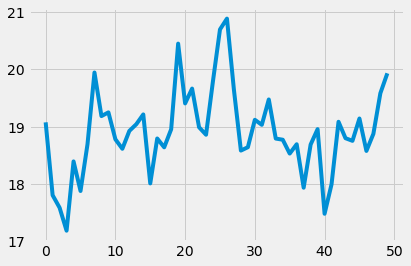

MTA3


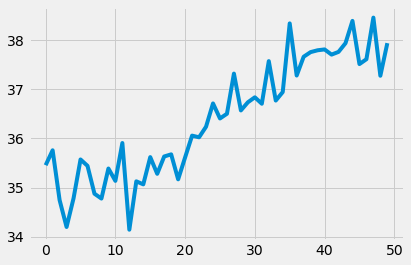

MXI1


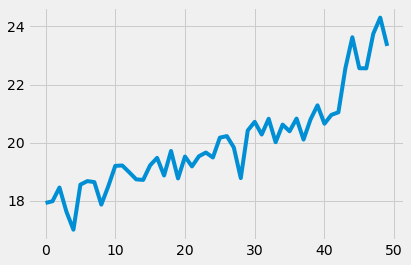

MYBL2


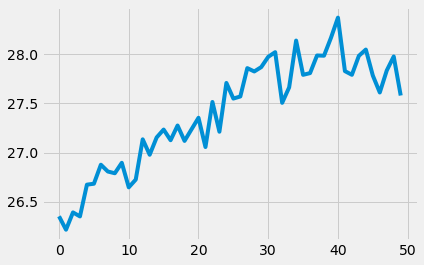

MYC


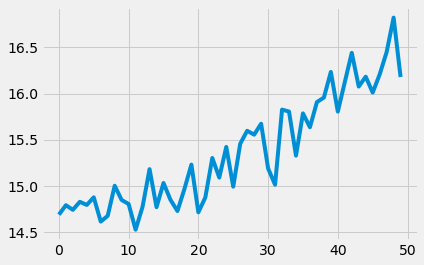

NANOG


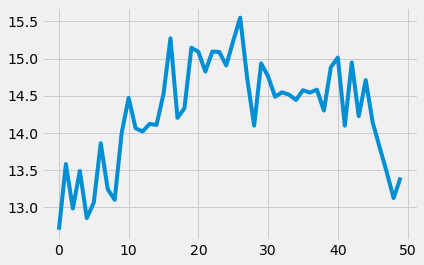

NCOA1


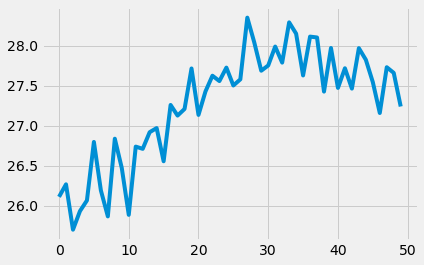

NCOR1


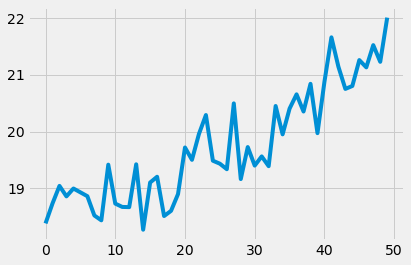

NCOR2


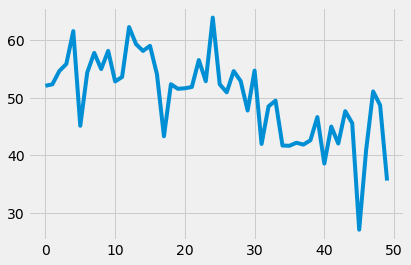

NELFE


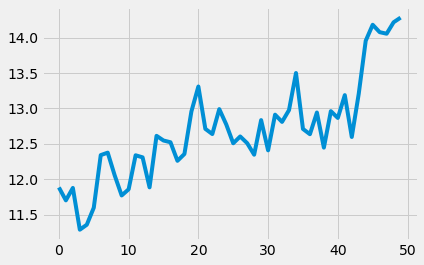

NF1C


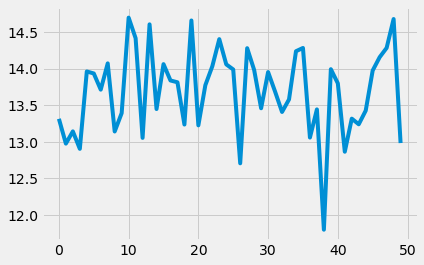

NFATC1


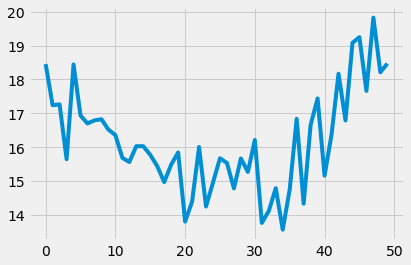

NFE2


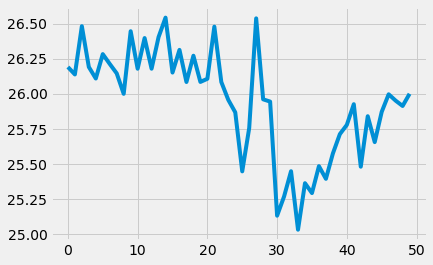

NFKB1


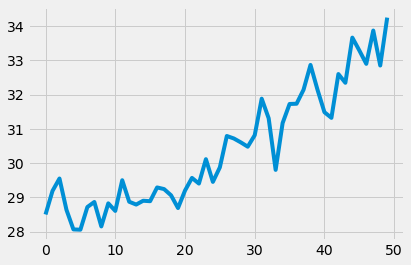

NFYA


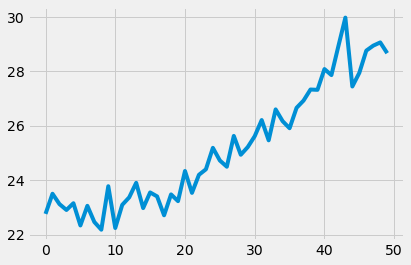

NFYB


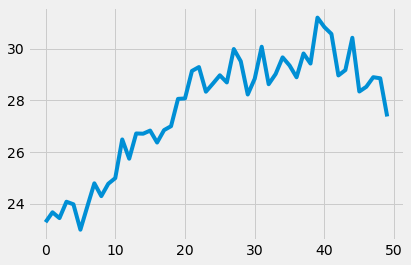

NIPBL


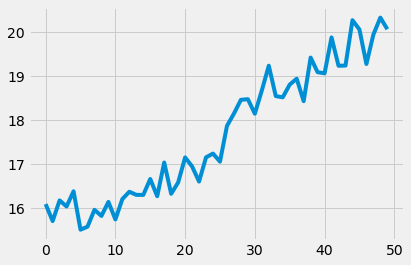

NKX2-1


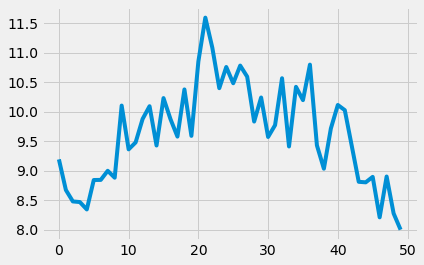

NKX3-1


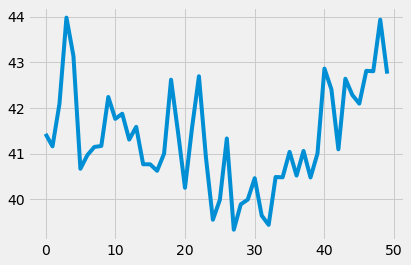

NOTCH1


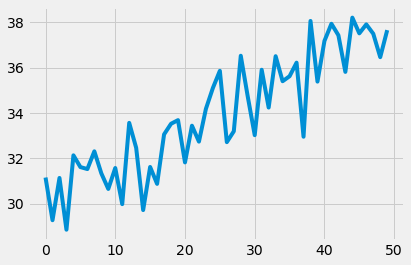

NR2C2


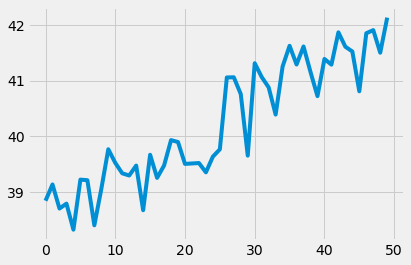

NR2F2


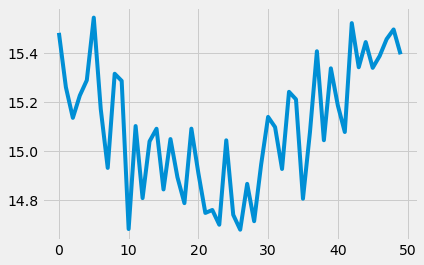

NR3C1


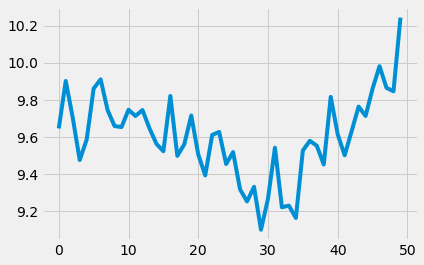

NR3C3


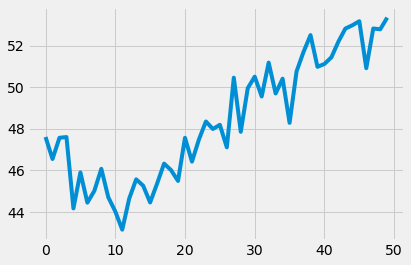

NRF1


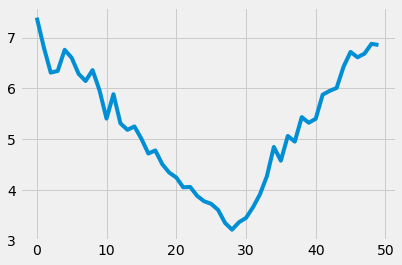

ONECUT1


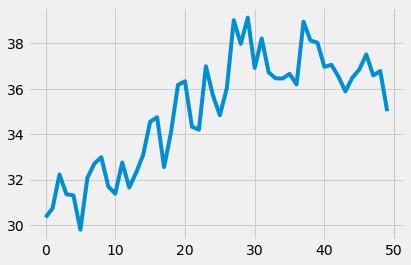

ORC1


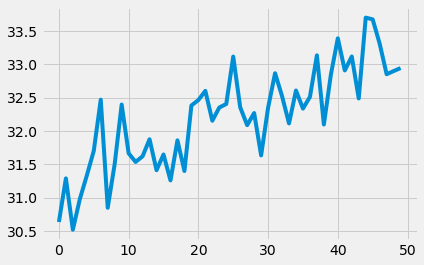

PAX5


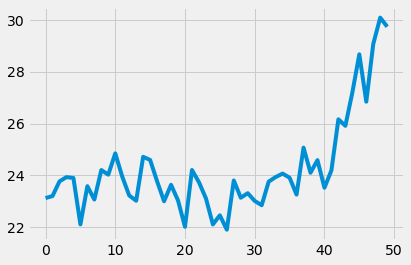

PBX3


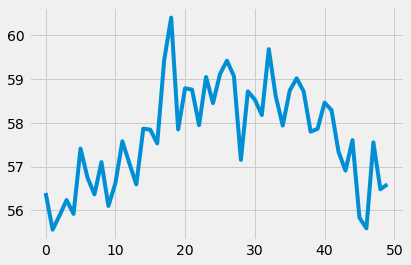

PHF8


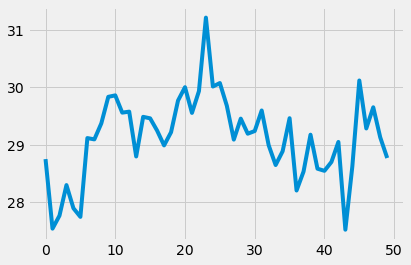

PML


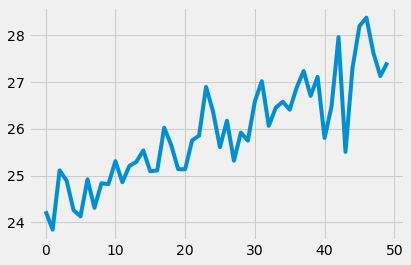

POU2F2


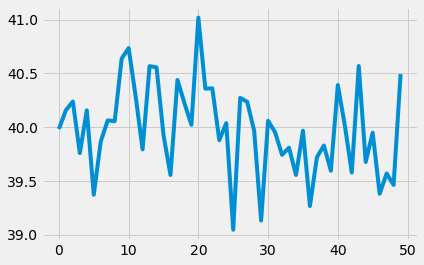

POU5F1


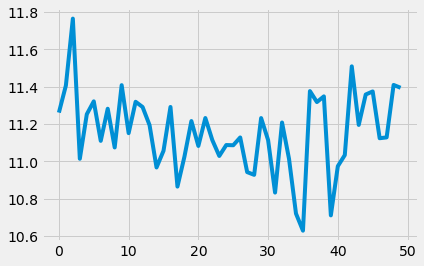

PPARG


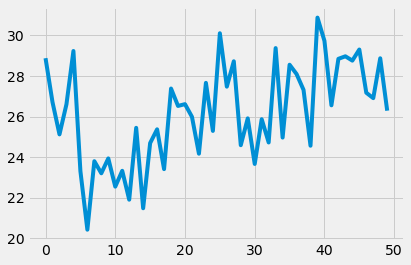

PPARGC1A


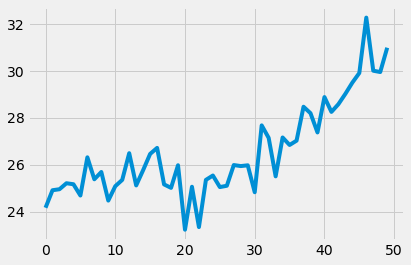

PRAME


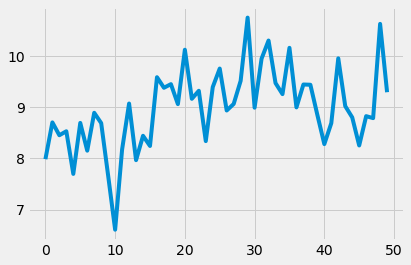

PRDM1


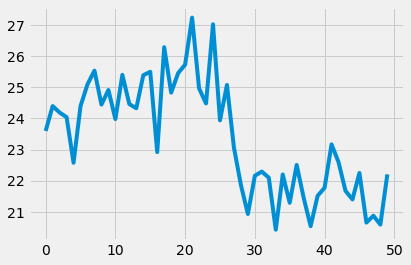

PRDM14


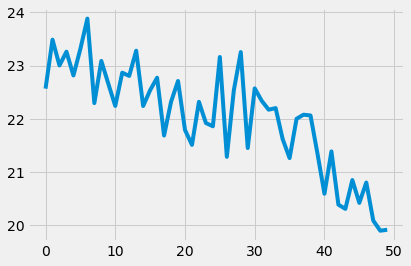

RAC3


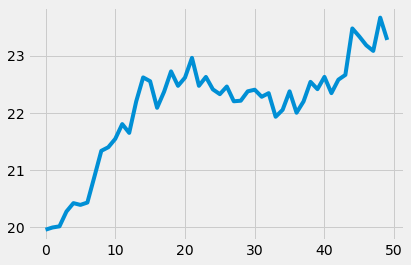

RAD21


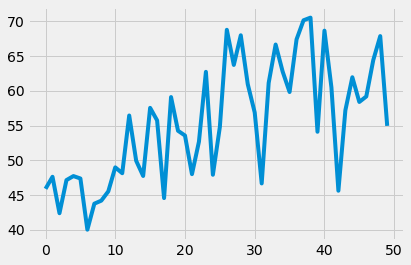

RB1


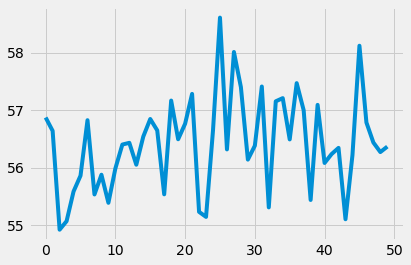

RBBP5


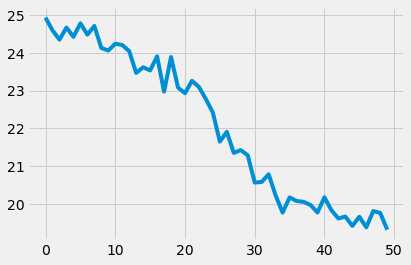

RBPJ


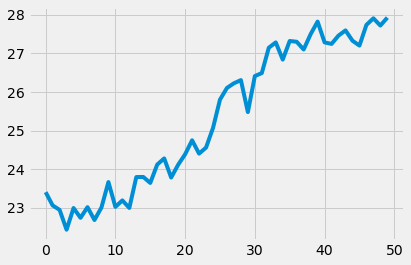

RCOR1


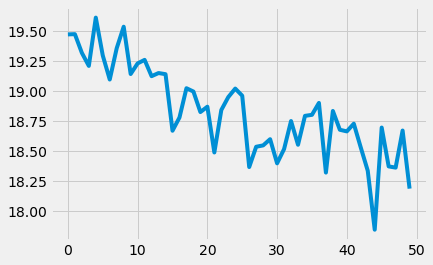

RELA


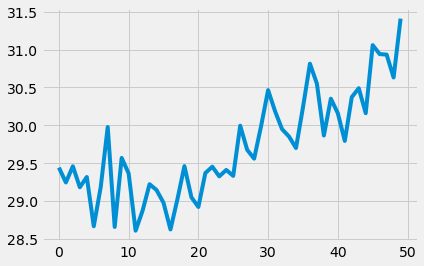

REST


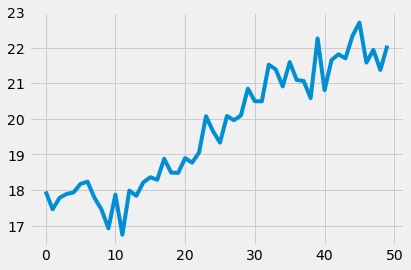

RFX5


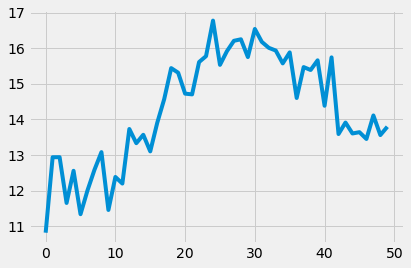

RNF2


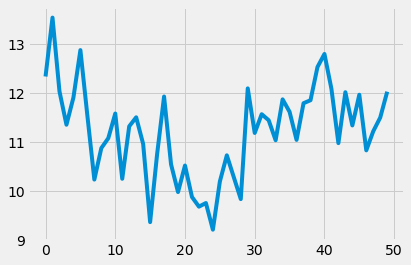

RPC155


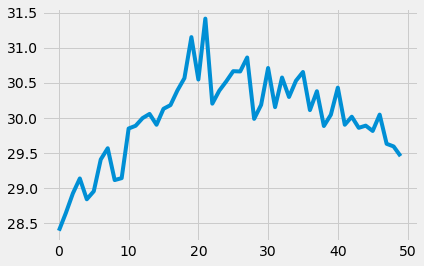

RUNX1


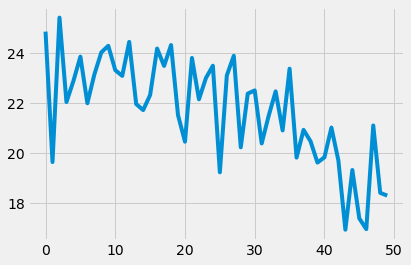

RUNX1+3


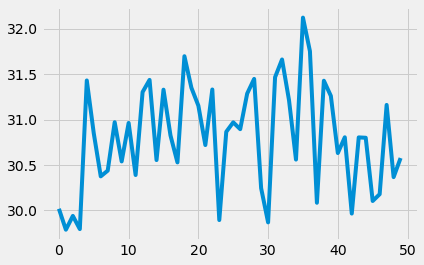

RUNX1T1


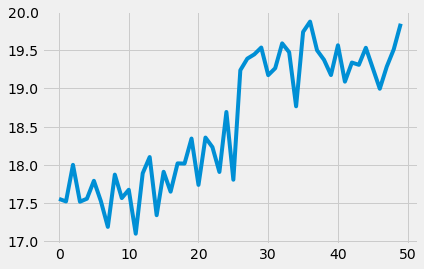

RUNX2


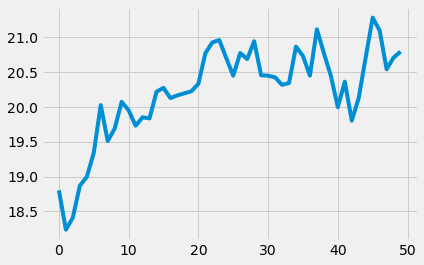

RUNX3


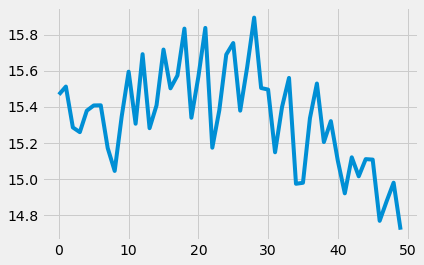

RXRA


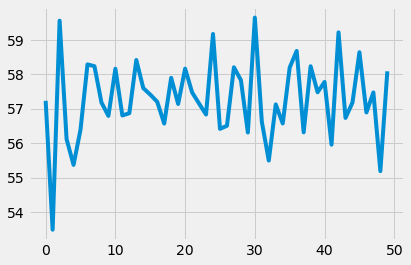

SAP30


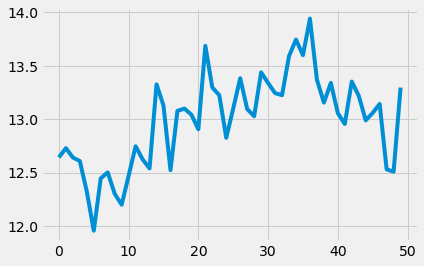

SETDB1


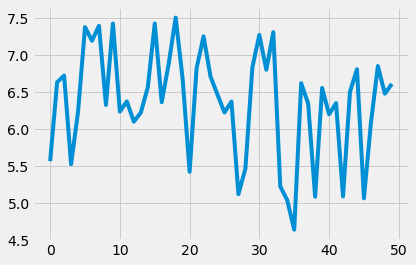

SFMBT1


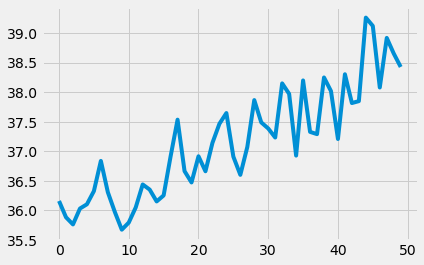

SIN3A


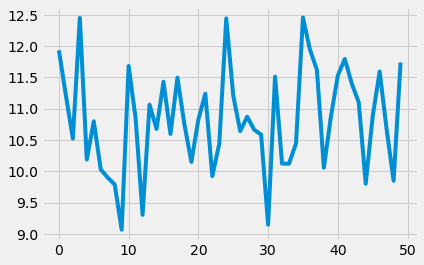

SIRT6


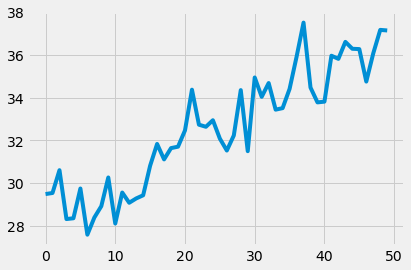

SIX5


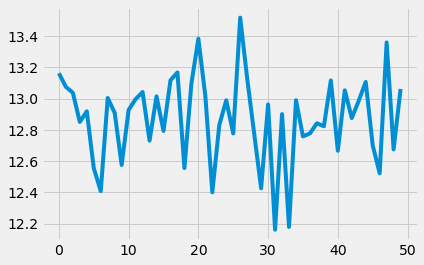

SMAD1


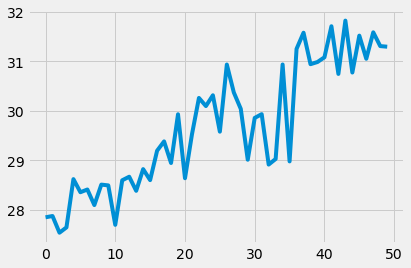

SMAD2+3


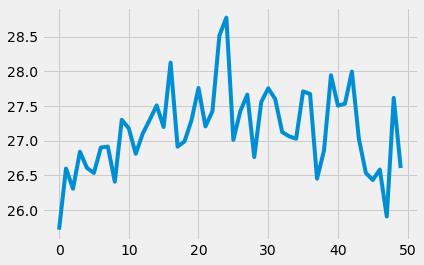

SMAD3


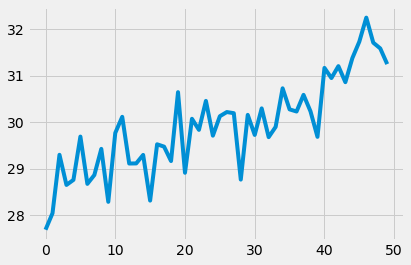

SMAD4


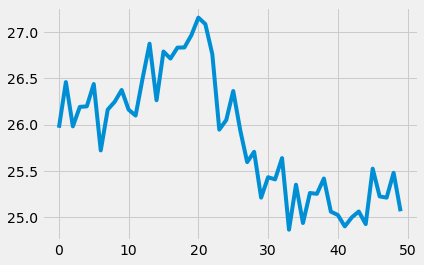

SMARCA4


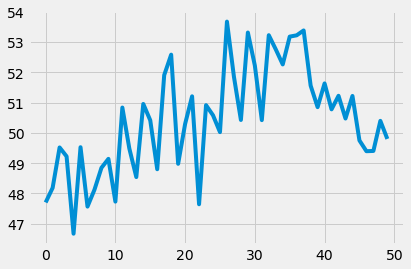

SMARCB1


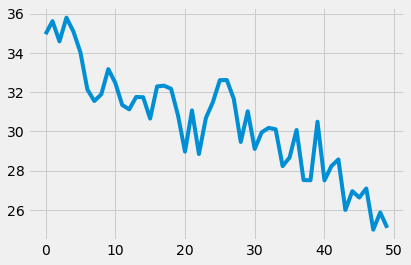

SMARCC1


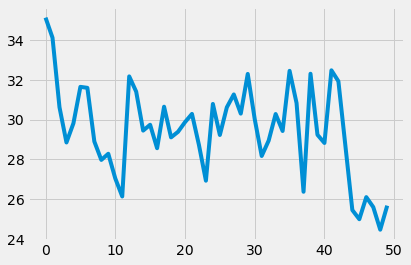

SMARCC2


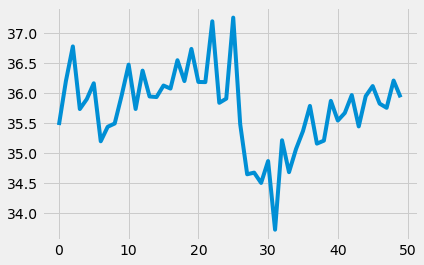

SMC1A


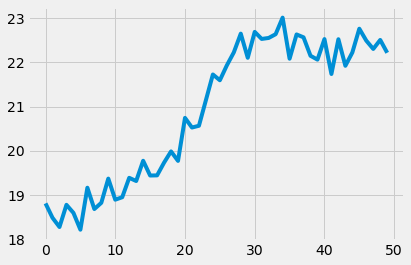

SMC3


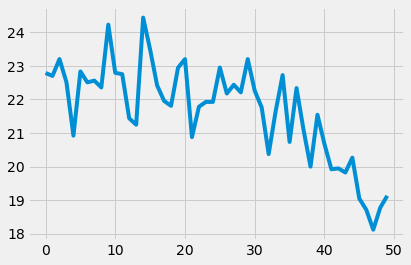

SMC4


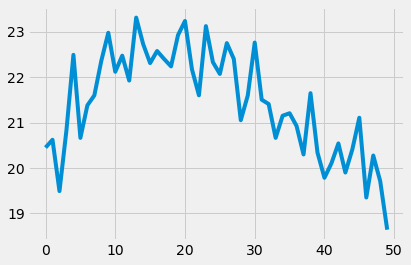

SNAPC1


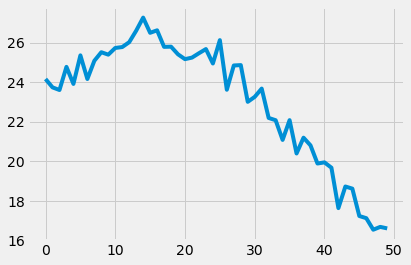

SNAPC4


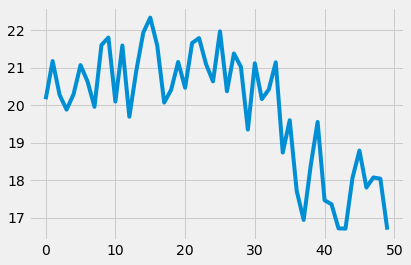

SNAPC5


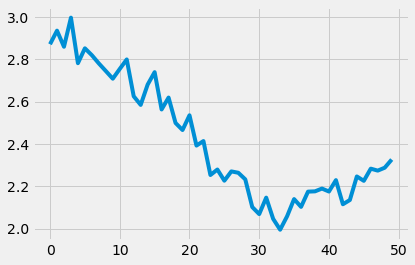

SOX2


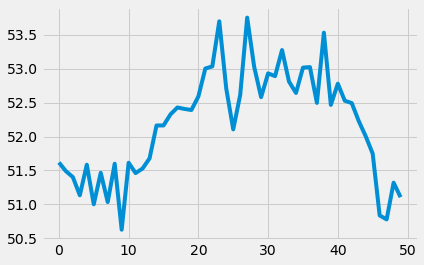

SP1


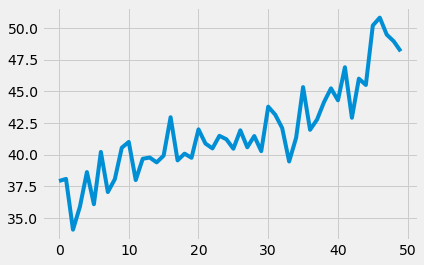

SP2


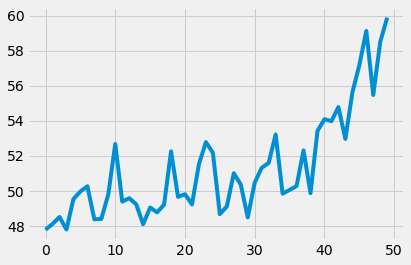

SP4


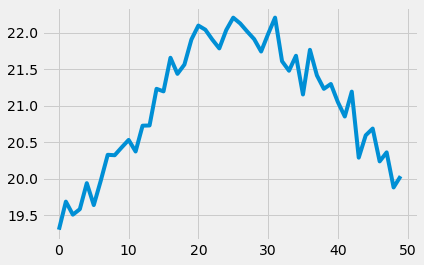

SPI1


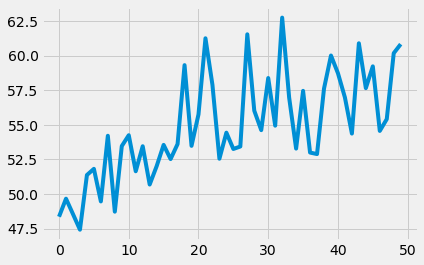

SREBP1


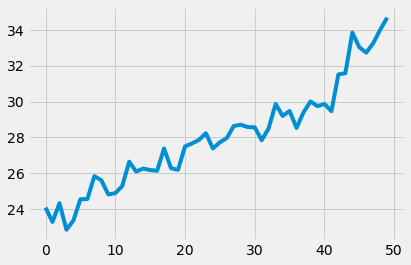

SRF


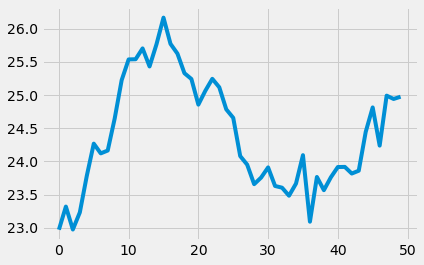

STAG1


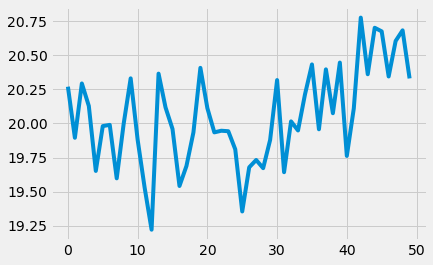

STAT1


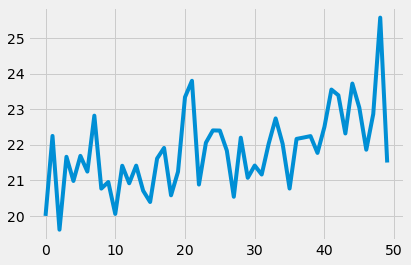

STAT2


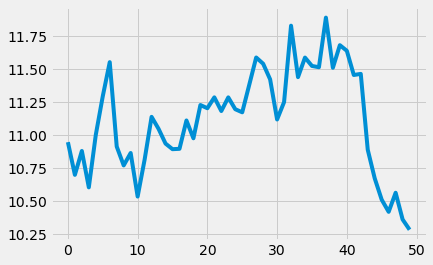

STAT3


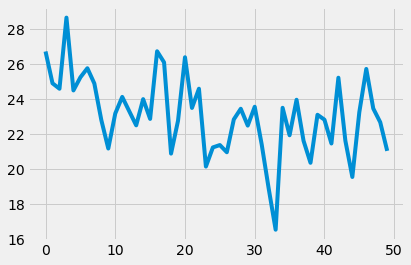

STAT4


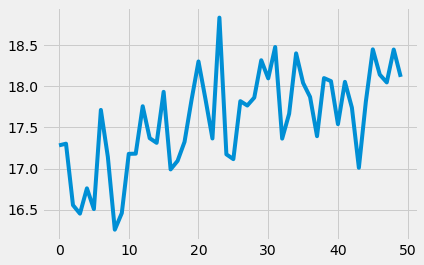

STAT5A


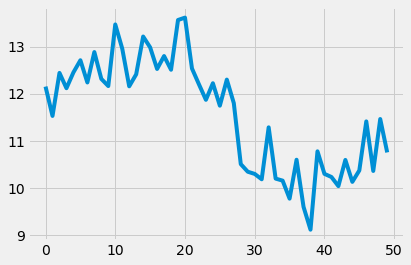

STAT5B


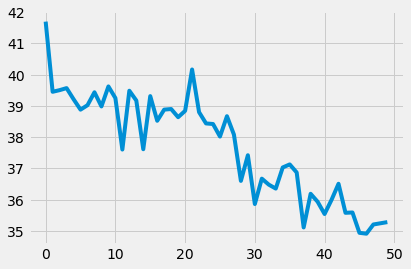

SUZ12


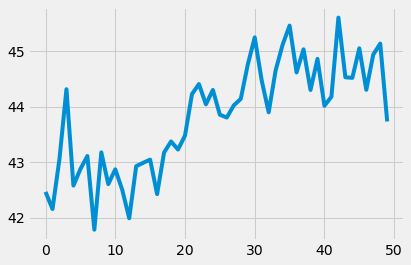

TAF1


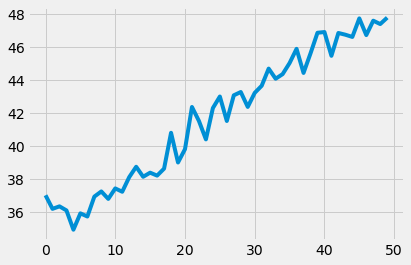

TAF2


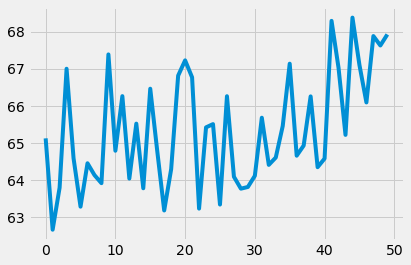

TAF3


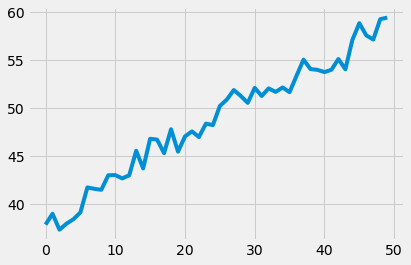

TAF7


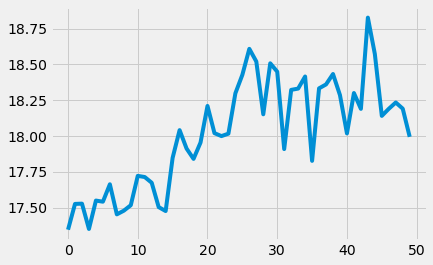

TAL1


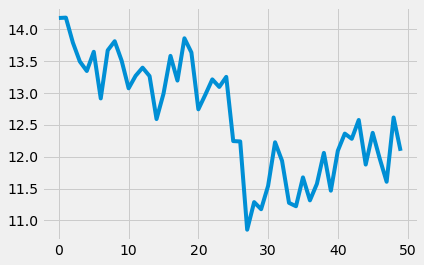

TAp73a


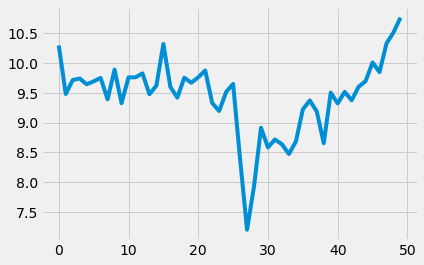

TAp73b


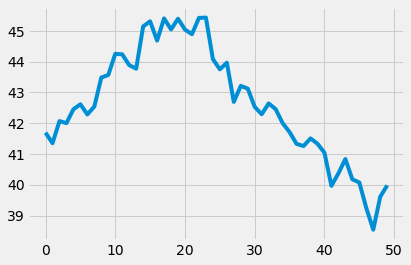

TBL1


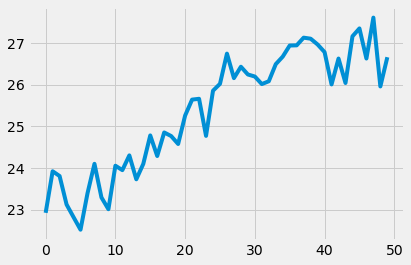

TBL1XR1


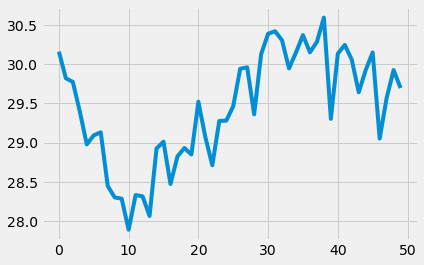

TBP


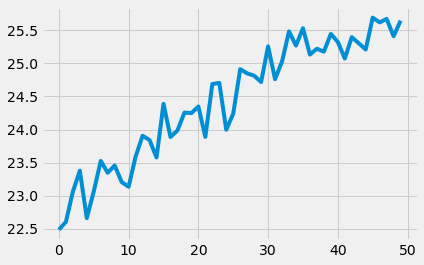

TCF12


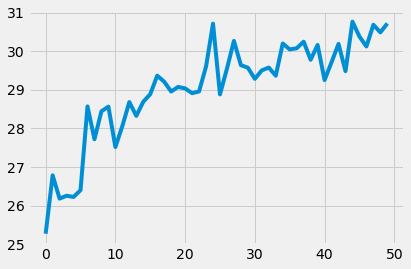

TCF3


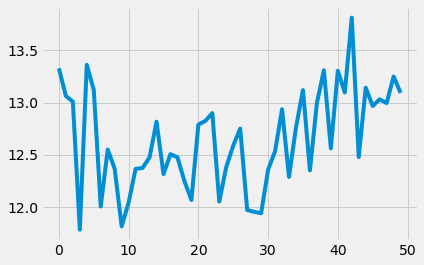

TCF4


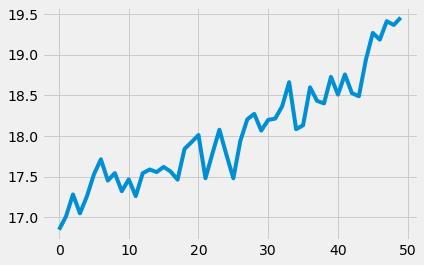

TCF7L2


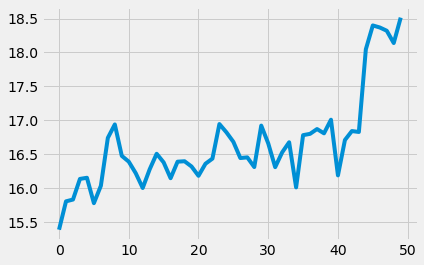

TEAD4


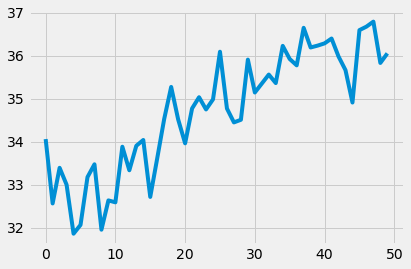

TFAP2A


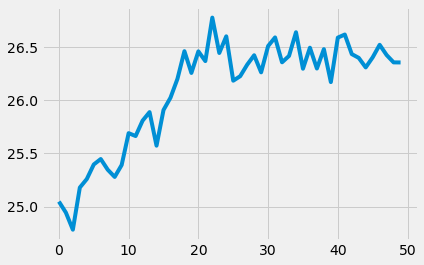

TFAP2C


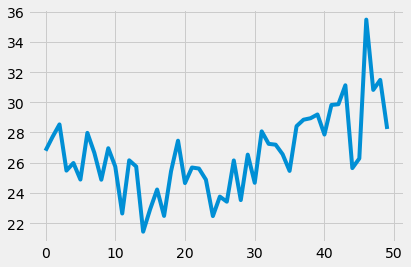

TFAP4


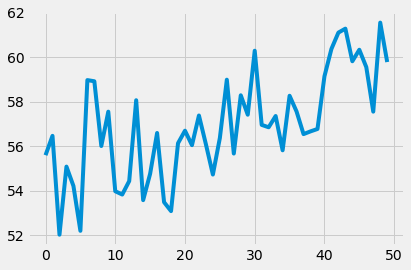

THAP1


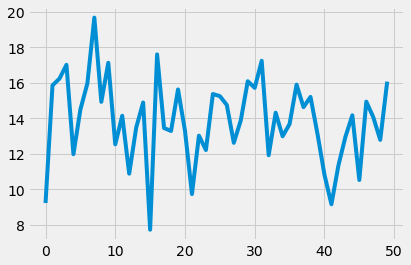

TLE3


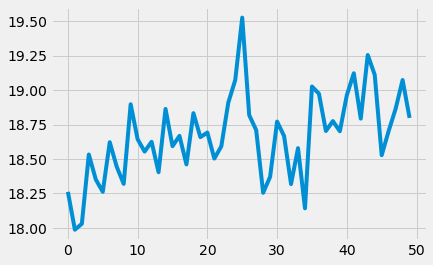

TP53


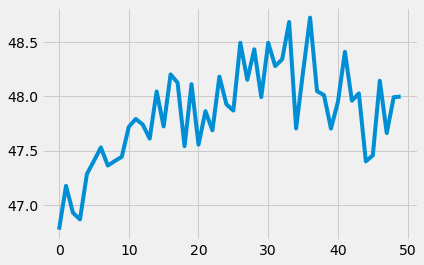

TP63


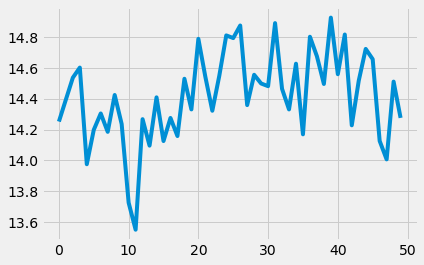

TRIM28


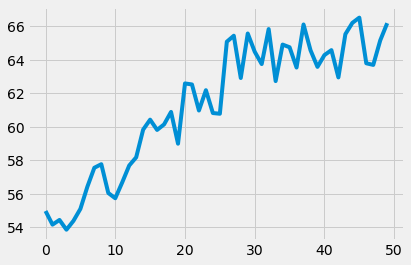

UBTF


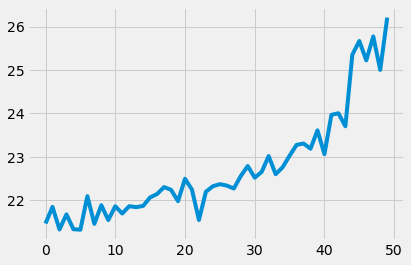

USF1


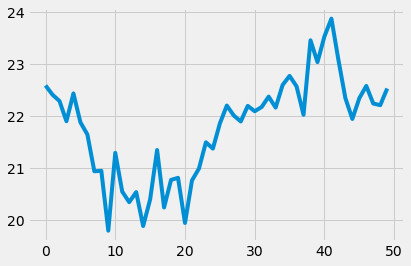

USF2


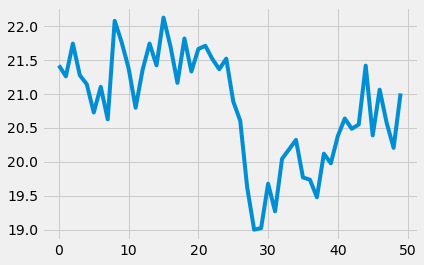

VDR


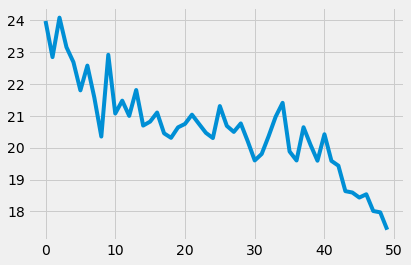

WRNIP1


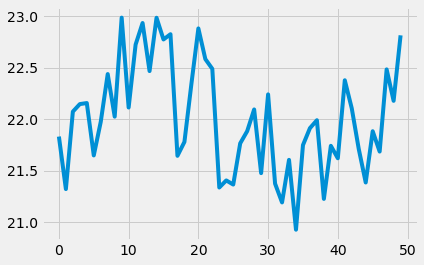

XPB


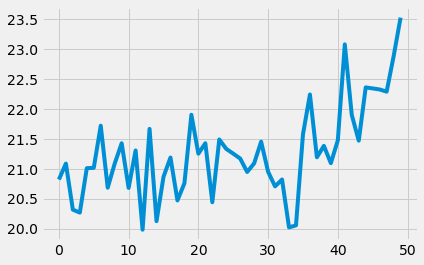

XPD


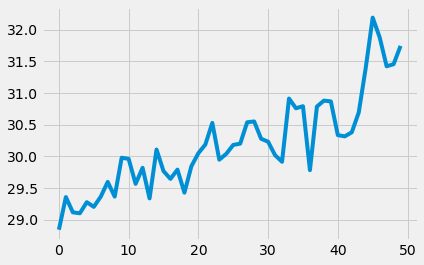

YY1


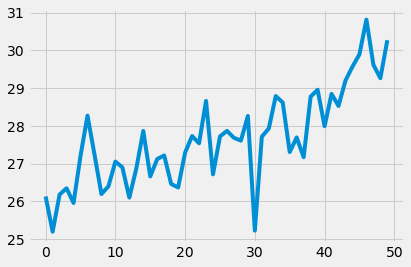

ZBTB33


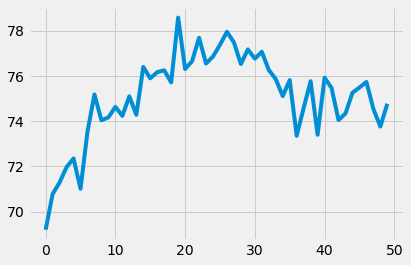

ZBTB7A


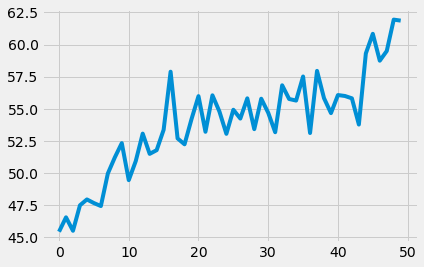

ZEB1


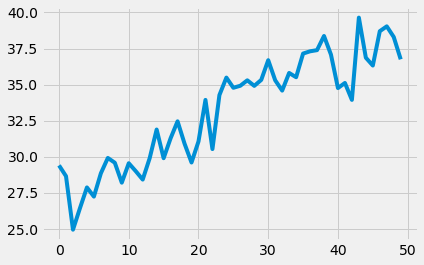

ZKSCAN1


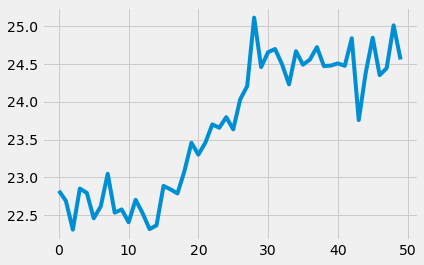

ZNF143


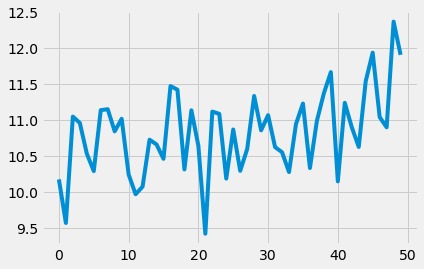

ZNF217


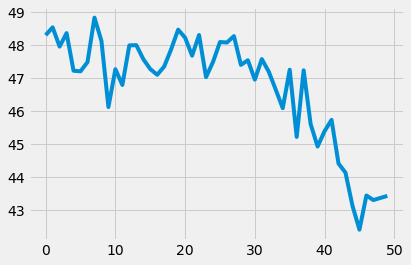

ZNF263


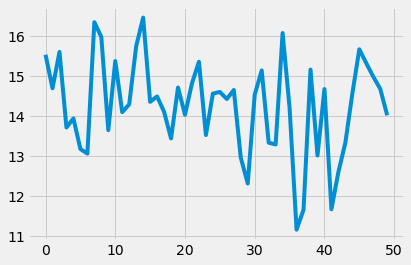

ZNF274


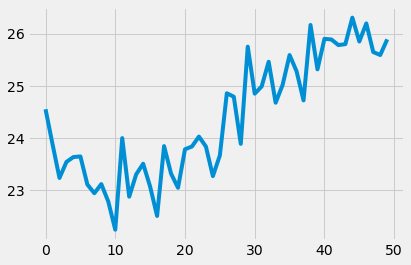

ZNF76


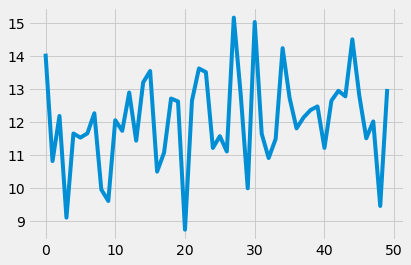

ZZZ3


In [118]:
for i,j in zip(mean_scores, tfs):
    plt.plot(i)
    plt.show()
    print (j)

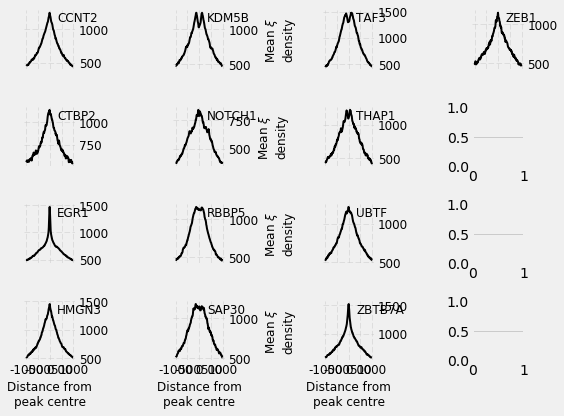

In [111]:
fig, axis = plt.subplots(4, 4, figsize=(8, 6))
row = 0
col = 0
for i,s in zip(range(len(mean_scores)), mean_scores):
    ax = axis[row, col]
    ax.plot([sum(s[x:x+10]) for x in range(0, 2010, 10)][:-1], lw=2, c='k')
    ax.text(0.65, 0.8, sig_tfs[i], fontsize=12, transform=ax.transAxes)
    
    ax.set_xticks([0, 50, 100, 150, 200])
    if i in  [3, 7, 11]:
        ax.set_xticklabels([-1000, -500, 0, 500, 1000])
        ax.set_xlabel('Distance from\npeak centre', fontsize=12)
    else:
        ax.set_xticklabels([])
        
    if col == 1:
        ax.set_ylabel('Mean ' + r'$\xi$' + '\ndensity', fontsize=12)
    else:
        pass
    
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    clean_axis(ax)
    
    row += 1
    if row == 4:
        row = 0
        col += 1

plt.tight_layout()
plt.savefig('../images/select_tfbs_density.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/select_tfbs_density.svg', transparent=True, edgecolor='none')
plt.show()

In [524]:
def get_g4s_in_peaks(chrom):
    
    import pybedtools as pbt
    import numpy as np
    
    def make_control_bed(bed):
        c_bed = []
        for i in bed:
            c = str(i).rstrip('\n').split('\t')
            c_bed.append('\t'.join([c[0], str(int(c[1])-350), str(int(c[1])-300)]))
        return pbt.BedTool('\n'.join(c_bed), from_string=True)
    
    def randomize_bed(bed):
        l = bed.count()
        r_bed = []
        if l > 50:
            r_bed = [str(bed[np.random.randint(l)]) for x in range(50)]
            return pbt.BedTool('\n'.join(r_bed), from_string=True)
        else:
            return bed

    res = []
    select_tfs = ['CTCFL', 'EGR1', 'FOXP2', 'MAZ', 'SP1', 'TBL1', 'ZBTB7A', 'ZEB1']    
    tf_dir = '/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files'
    g4_dir = '/home/parashar/scratch/quadruplexes/hg19'
    g4_bed = pbt.BedTool("%s/g3_50_3_%s_nov.bed" % (g4_dir, chrom))
    
    for tf in select_tfs:
        tf_bed = pbt.BedTool("%s/%s/%s.bed" % (tf_dir, tf, chrom))
        tot = tf_bed.count()
        if tot > 0:
            tf_bed = randomize_bed(tf_bed)
            intersect = tf_bed.intersect(g4_bed, u=True)
            control_intersect = make_control_bed(tf_bed).intersect(g4_bed, u=True)
            a = intersect.count()
            b = control_intersect.count()
            tot = tf_bed.count()
            res.append([a, tot-a, b, tot-b])
        else:
            res.append([0, 0, 0, 0])
    return res

In [523]:
g4_15_0_rep_res = []
for i in tqdm(range(100)):
    g4_15_0_rep_res.append(np.array(DVIEW.map_sync(get_g4s_in_peaks, chroms)).sum(axis=0))
g4_15_0_rep_res = np.array(g4_15_0_rep_res)

100%|██████████| 100/100 [2:28:30<00:00, 89.35s/it] 


In [528]:
x = g4_15_0_rep_res.mean(axis=0)

In [529]:
for i in g4_15_0_rep_res[1]:
    print (i)
    t_peaks = i[0] + i[1]
    p = binom_test(i[0]//10, t_peaks//10,
             p=i[2]/(i[2]+i[3]), alternative='greater')
    print (p)

[1147    3 1050  100]
0.000341957536035
[1141    9 1049  101]
0.000309545799636
[1106   44  999  151]
0.00156129344689
[1131   20 1056   95]
0.00321033512422
[1160   40 1081  119]
0.00606859488767
[1194    6  987  213]
1.76200481876e-09
[1148    4 1095   57]
0.0204096673427
[1139    3 1055   87]
0.00124141638188


In [504]:
for i in res:
    print (i)
    t_peaks = i[0] + i[1]
    p = binom_test(i[0]//10, t_peaks//10,
             p=i[2]/(i[2]+i[3]), alternative='greater')
    print (p)

[1145    5 1059   91]
0.000830789618918
[1137   13 1043  107]
0.00108422540253
[1097   53  999  151]
0.0046911943332
[1135   16 1024  127]
0.000168123879334
[1152   48 1075  125]
0.0112984157936
[1191    9 1008  192]
1.95493696498e-08
[1150    2 1081   71]
0.000665150174883
[1140    2 1049   93]
6.22973837496e-05


In [498]:
for i in res:
    print (i)
    t_peaks = i[0] + i[1]
    p = binom_test(i[0]//10, t_peaks//10,
             p=i[2]/(i[2]+i[3]), alternative='greater')
    print (p)

[1143    7 1042  108]
0.000153383240007
[1138   12 1066   84]
0.00826766526414
[1100   50  980  170]
0.000326733874229
[1131   20 1045  106]
0.00119784344765
[1153   47 1076  124]
0.0121273612963
[1194    6 1001  199]
8.826195149e-09
[1149    3 1071   81]
0.00221519977213
[1141    1 1034  108]
1.20616180762e-05


In [475]:
res

array([[11474,    59, 10551,   982],
       [44546,   433, 41039,  3940],
       [26309,  1341, 23933,  3717],
       [43104,   804, 40138,  3770],
       [95365,  3819, 88562, 10622],
       [44862,   306, 37084,  8084],
       [24978,    75, 23712,  1341],
       [ 4796,    11,  4448,   359]])